Title of Final Project: Child Mind Institute - Detect Sleep States

Section: 52745


Student Name: Thomas Wynn

Student UT EID: ttw483

Date: 10/30/23


In [1]:
import streamlit as st

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from IPython.display import Markdown
import gc

train_events_path = "/Users/thomaswynn/Desktop/sleep_kaggle/child-mind-institute-detect-sleep-states/train_events.csv"
train_series_path = "/Users/thomaswynn/Desktop/sleep_kaggle/child-mind-institute-detect-sleep-states/train_series.parquet"



## In this code competition, the testing dataset is hidden. However, it is in the same format as train_series

-------------
# 1 Getting Familiar with the dataset

In [2]:
train_events = pd.read_csv(train_events_path)
train_series = pd.read_parquet(train_series_path)


train_events.head()

series_id  night   event     step                 timestamp
0  038441c925bb      1   onset   4992.0  2018-08-14T22:26:00-0400
1  038441c925bb      1  wakeup  10932.0  2018-08-15T06:41:00-0400
2  038441c925bb      2   onset  20244.0  2018-08-15T19:37:00-0400
3  038441c925bb      2  wakeup  27492.0  2018-08-16T05:41:00-0400
4  038441c925bb      3   onset  39996.0  2018-08-16T23:03:00-0400

In [3]:
train_series

series_id    step                 timestamp     anglez    enmo
0          038441c925bb       0  2018-08-14T15:30:00-0400   2.636700  0.0217
1          038441c925bb       1  2018-08-14T15:30:05-0400   2.636800  0.0215
2          038441c925bb       2  2018-08-14T15:30:10-0400   2.637000  0.0216
3          038441c925bb       3  2018-08-14T15:30:15-0400   2.636800  0.0213
4          038441c925bb       4  2018-08-14T15:30:20-0400   2.636800  0.0215
...                 ...     ...                       ...        ...     ...
127946335  fe90110788d2  592375  2017-09-08T00:14:35-0400 -27.277500  0.0204
127946336  fe90110788d2  592376  2017-09-08T00:14:40-0400 -27.032499  0.0233
127946337  fe90110788d2  592377  2017-09-08T00:14:45-0400 -26.841200  0.0202
127946338  fe90110788d2  592378  2017-09-08T00:14:50-0400 -26.723900  0.0199
127946339  fe90110788d2  592379  2017-09-08T00:14:55-0400 -31.521601  0.0205

[127946340 rows x 5 columns]

In [4]:
train_series["series_id"].nunique()

277

^^ There are 277 unique series!

In [5]:
train_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127946340 entries, 0 to 127946339
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   series_id  object 
 1   step       uint32 
 2   timestamp  object 
 3   anglez     float32
 4   enmo       float32
dtypes: float32(2), object(2), uint32(1)
memory usage: 3.3+ GB


In [6]:
print("Shape of train_events : {:,} Rows, {} Columns\nShape of train_series : {:,} Rows, {} Columns".format(train_events.shape[0], train_events.shape[1], train_series.shape[0], train_series.shape[1]))

Shape of train_events : 14,510 Rows, 5 Columns
Shape of train_series : 127,946,340 Rows, 5 Columns


In [7]:
print(train_series["series_id"].describe())

count        127946340
unique             277
top       78569a801a38
freq           1433880
Name: series_id, dtype: object


In [8]:
print(train_series["step"].describe())
print(train_series["step"].max() - train_series["step"].min())

count    1.279463e+08
mean     2.548048e+05
std      1.778930e+05
min      0.000000e+00
25%      1.158120e+05
50%      2.345190e+05
75%      3.571960e+05
max      1.433879e+06
Name: step, dtype: float64
1433879


In [9]:
print(train_series["anglez"].describe())
print(train_series["anglez"].max() - train_series["step"].min())

count    1.279463e+08
mean    -8.810453e+00
std      3.552188e+01
min     -9.000000e+01
25%     -3.185890e+01
50%     -9.597900e+00
75%      1.130020e+01
max      9.000000e+01
Name: anglez, dtype: float64
90.0


In [10]:
print(train_series["enmo"].describe())
print(train_series["enmo"].max() - train_series["step"].min())

count    1.279463e+08
mean     4.131503e-02
std      1.018289e-01
min      0.000000e+00
25%      1.300000e-03
50%      1.720000e-02
75%      4.370000e-02
max      1.143370e+01
Name: enmo, dtype: float64
11.433699607849121


In [11]:
train_events.describe()

night          step
count  14510.000000    9587.00000
mean      15.118952  214330.96610
std       10.286598  141264.08126
min        1.000000     936.00000
25%        7.000000   95418.00000
50%       14.000000  200556.00000
75%       21.000000  317472.00000
max       84.000000  739392.00000

In [12]:
train_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14510 entries, 0 to 14509
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   series_id  14510 non-null  object 
 1   night      14510 non-null  int64  
 2   event      14510 non-null  object 
 3   step       9587 non-null   float64
 4   timestamp  9587 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 566.9+ KB


## We see that train_series is pretty large, with unique series (comprising of multiple days) appended vertically in the dataframe. Each series represents a period of time in which a child has worn an acclerometer. Train_events only contains the events of awakening and sleeping, labeled by an expert psychiatrist (from the competition website), thus it is much smaller. Ideally, it would be nice to combine these into a single dataset for analysis and training.

---------------

# 2 Data Wrangling

In this first step, we should try to combine train_events with train_series to create a binary target feature "awake", where 0 represents the asleep state and 1 represents the awake state. This will make it easier to do EDA and prediction using machine learning. We should also drop series that have missing event data and make syure that every sleep event is matched with a corresponding awake event.

## Check that all of the data start with onset

In [13]:
train_events.groupby('series_id').head(1)["event"].unique()

array(['onset'], dtype=object)

## Check that series data ends with awake 

In [14]:
train_events.groupby('series_id').tail(1)["event"].unique()

array(['wakeup'], dtype=object)

## Check if any series has NaN

In [15]:
no_nan_series = train_events.groupby('series_id')['step'].apply(lambda x: x.isnull().any())
no_nan_series.value_counts()

step
True     240
False     37
Name: count, dtype: int64

## There are 240 series that are missing event data. If we train a machine learning model on these data, we could increase our probability of getting false negatives, since the event data (wakeuup/sleep times) simply aren't there!

In [16]:
no_nan_series = no_nan_series.drop('31011ade7c0a') # incomplete events data
no_nan_series = no_nan_series.drop('a596ad0b82aa') # incomplete events data

let remove these.

In [17]:
no_nan_series = no_nan_series[~no_nan_series].index.tolist()
print(len(no_nan_series))
no_nan_series

35


['08db4255286f',
 '0a96f4993bd7',
 '0cfc06c129cc',
 '1087d7b0ff2e',
 '10f8bc1f7b07',
 '18b61dd5aae8',
 '29c75c018220',
 '3452b878e596',
 '349c5562ee2c',
 '3664fe9233f9',
 '483d6545417f',
 '55a47ff9dc8a',
 '5acc9d63b5fd',
 '5f94bb3e1bed',
 '655f19eabf1e',
 '67f5fc60e494',
 '72bbd1ac3edf',
 '76237b9406d5',
 '7822ee8fe3ec',
 '89bd631d1769',
 '8e32047cbc1f',
 '939932f1822d',
 '9ee455e4770d',
 'a9a2f7fac455',
 'a9e5f5314bcb',
 'af91d9a50547',
 'b364205aba43',
 'c535634d7dcd',
 'c6788e579967',
 'c68260cc9e8f',
 'ca730dbf521d',
 'd150801f3145',
 'd25e479ecbb7',
 'd515236bdeec',
 'd5e47b94477e']

## In this function, we are combining train_series with train_events to create a binary dataset, for a given series ID. Time points where the individual are asleep are labeled 1 and awake, 0.

In [18]:
def get_train_series(series): # takes in a series ID and returns
    train_series = pd.read_parquet(train_series_path, filters=[('series_id','==',series)])
    train_events = pd.read_csv(train_events_path).query('series_id == @series')
    
    train_events = train_events.dropna()
    train_events["step"]  = train_events["step"].astype("int")
    train_events["awake"] = train_events["event"].replace({"onset":1,"wakeup":0})

    train = pd.merge(train_series, train_events[['step','awake']], on='step', how='left')
    train["awake"] = train["awake"].bfill(axis ='rows')

    train['awake'] = train['awake'].fillna(1) # awake
    train["awake"] = train["awake"].astype("int")
    return(train)

### Lets visualize this...

###  anglez for series 08db4255286f

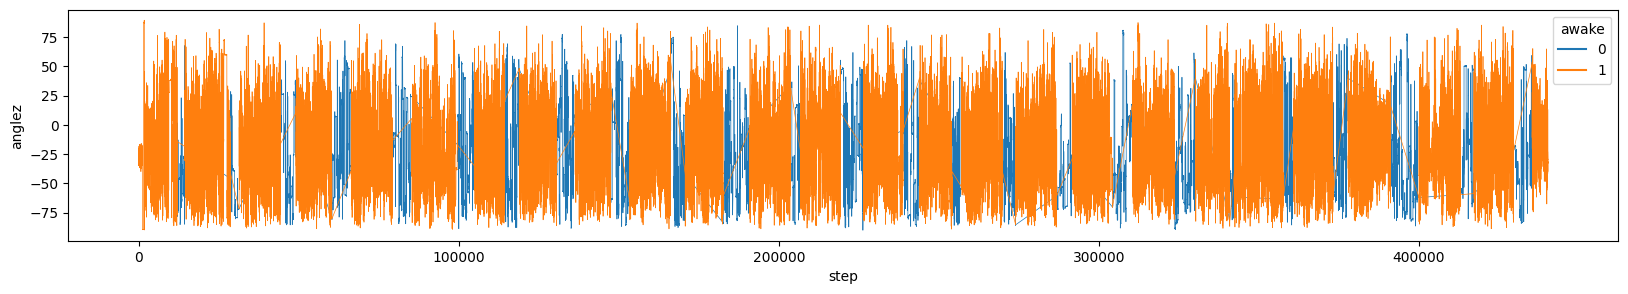

###  enmo for series 08db4255286f

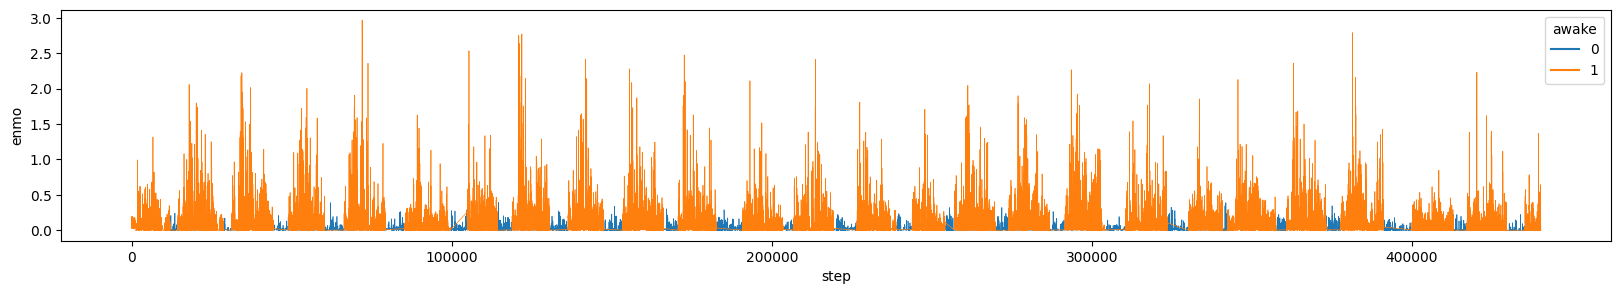

###  anglez for series 0a96f4993bd7

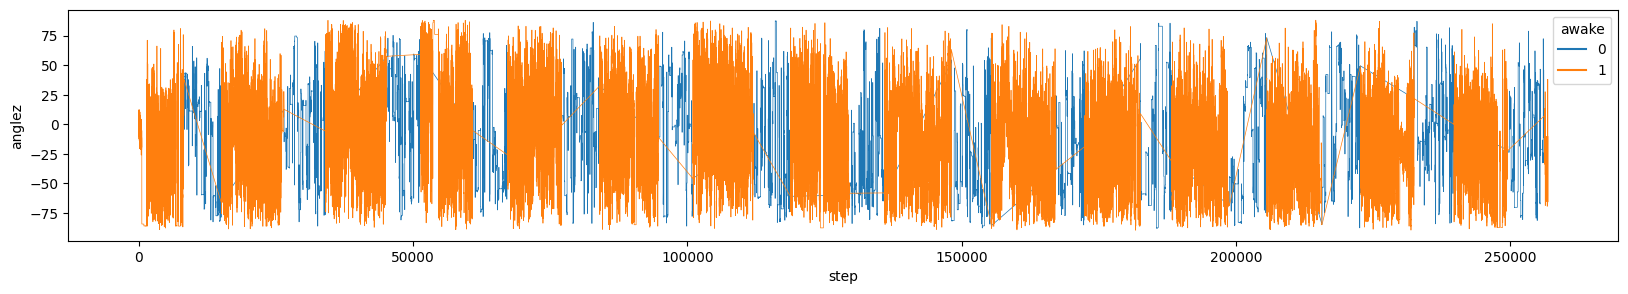

###  enmo for series 0a96f4993bd7

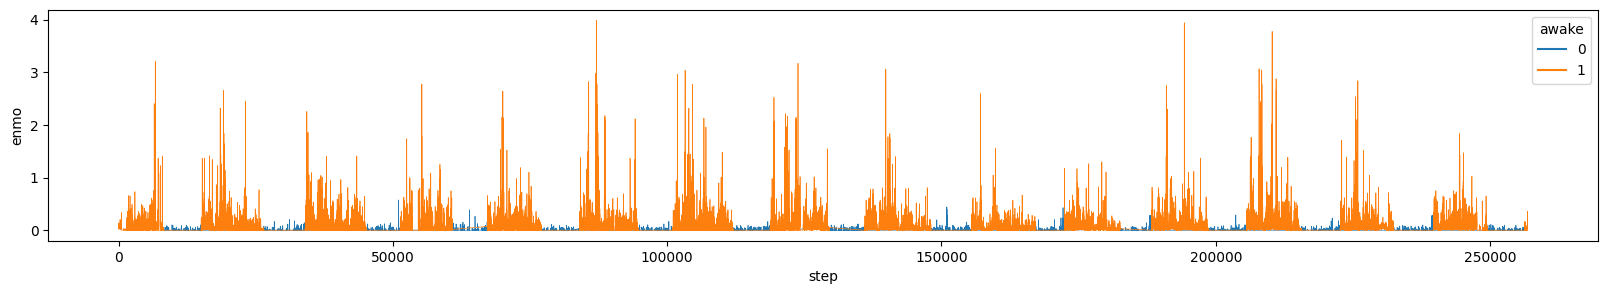

###  anglez for series 0cfc06c129cc

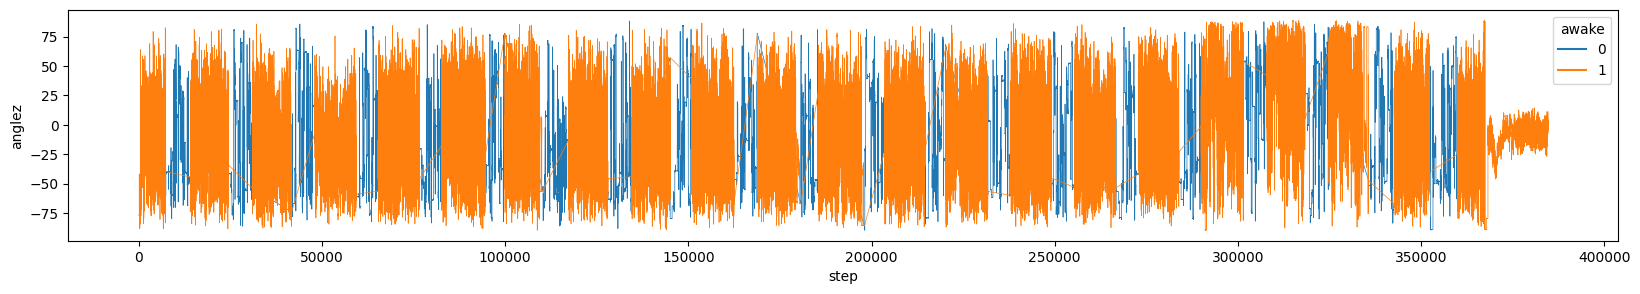

###  enmo for series 0cfc06c129cc

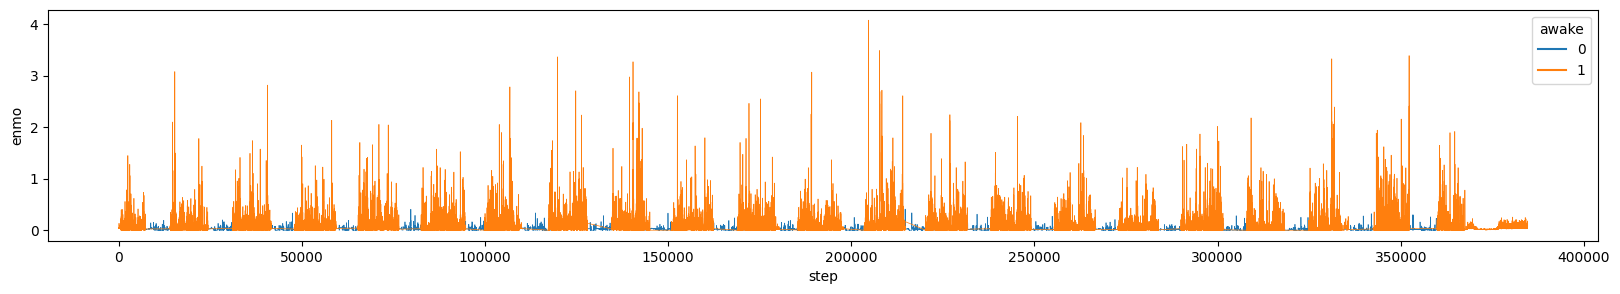

###  anglez for series 1087d7b0ff2e

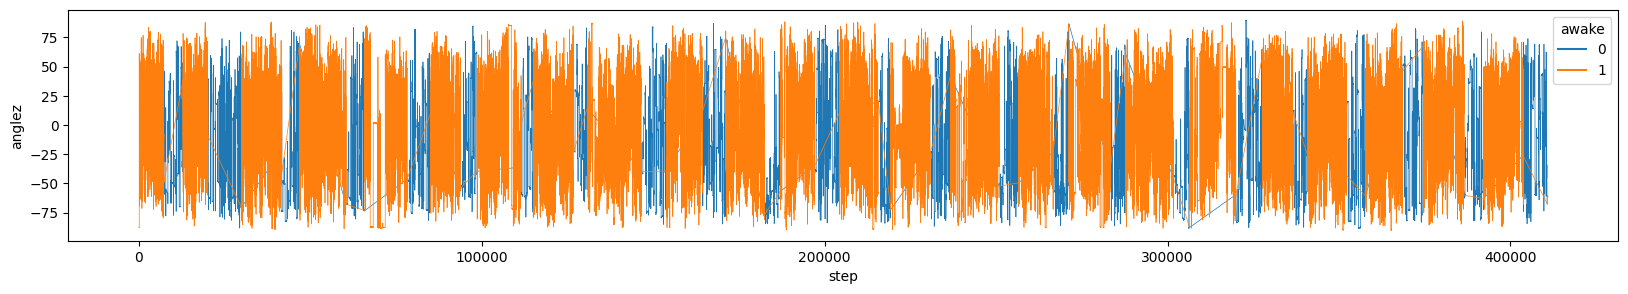

###  enmo for series 1087d7b0ff2e

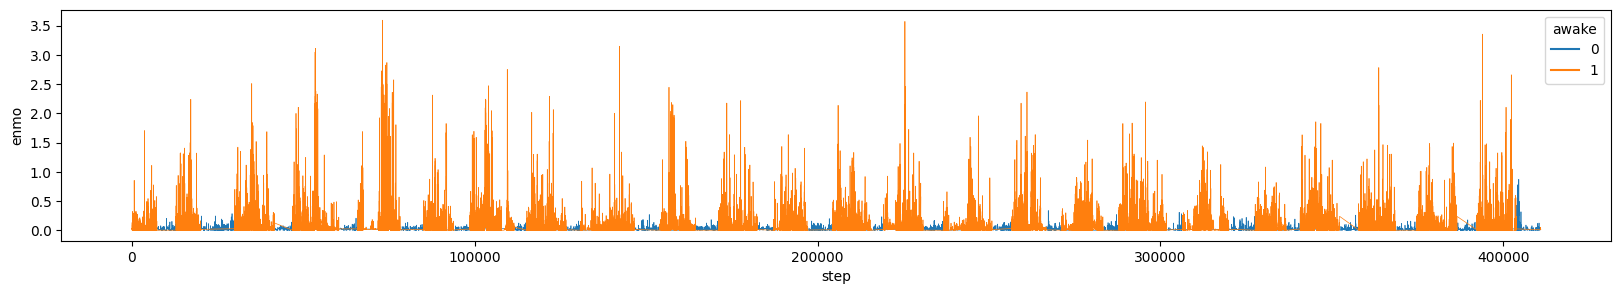

###  anglez for series 10f8bc1f7b07

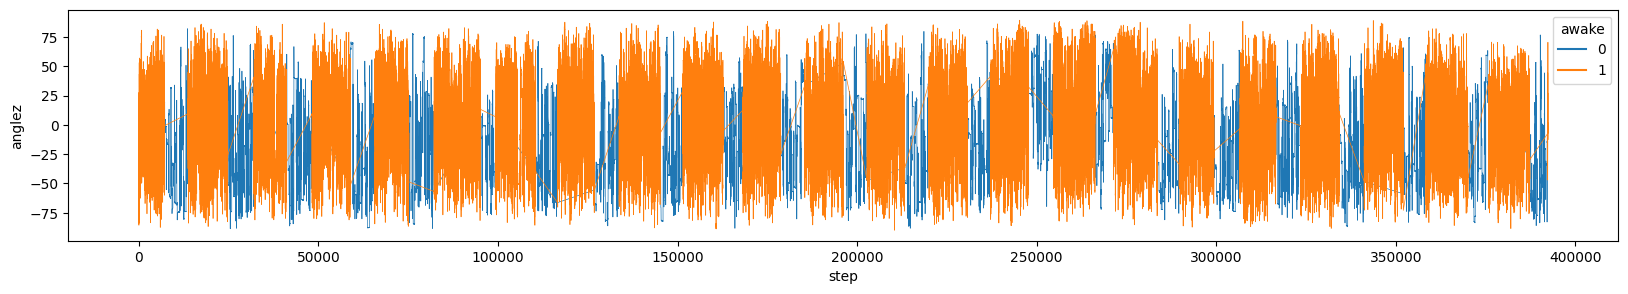

###  enmo for series 10f8bc1f7b07

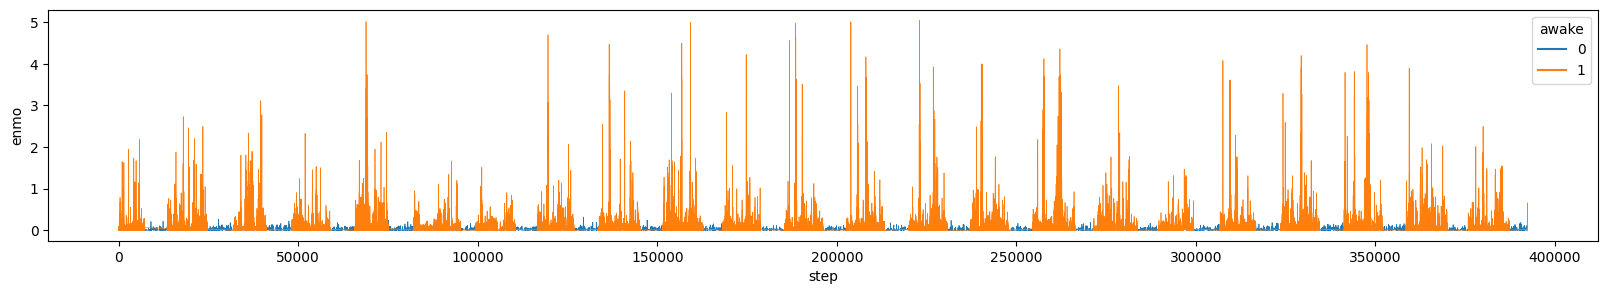

###  anglez for series 18b61dd5aae8

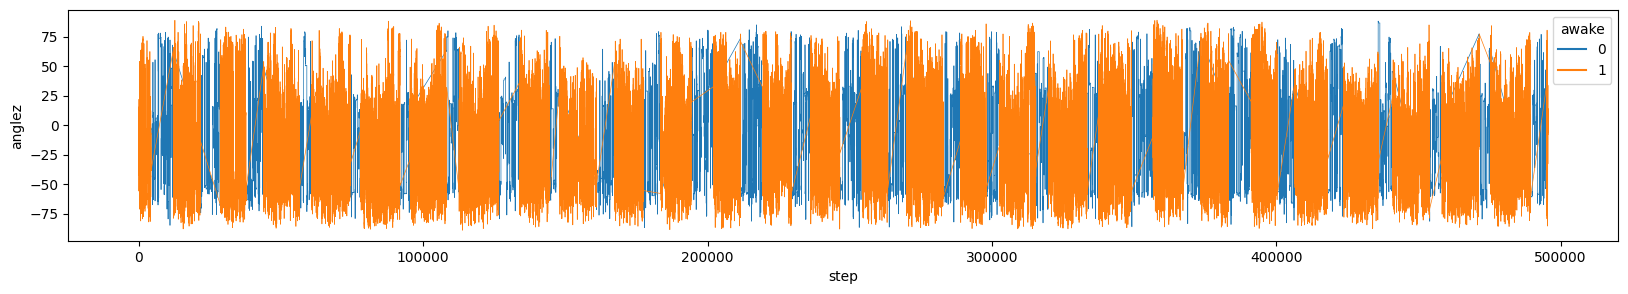

###  enmo for series 18b61dd5aae8

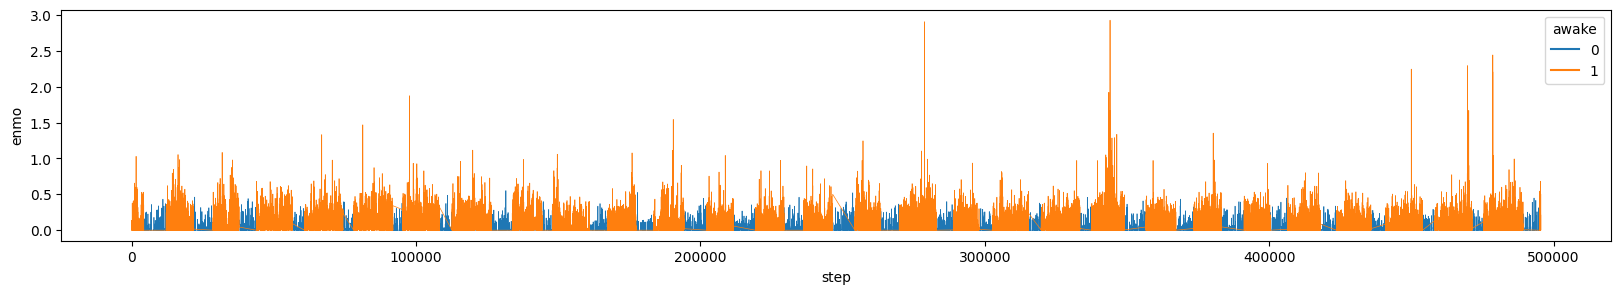

###  anglez for series 29c75c018220

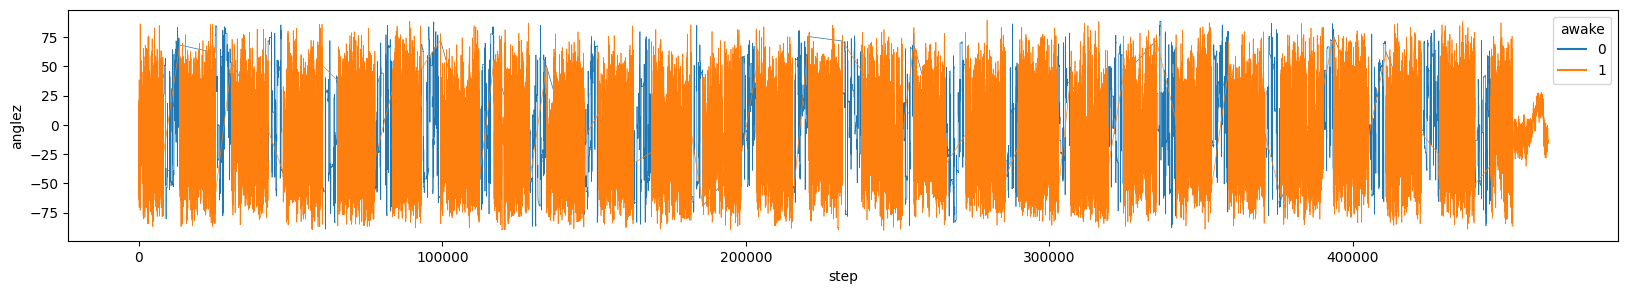

###  enmo for series 29c75c018220

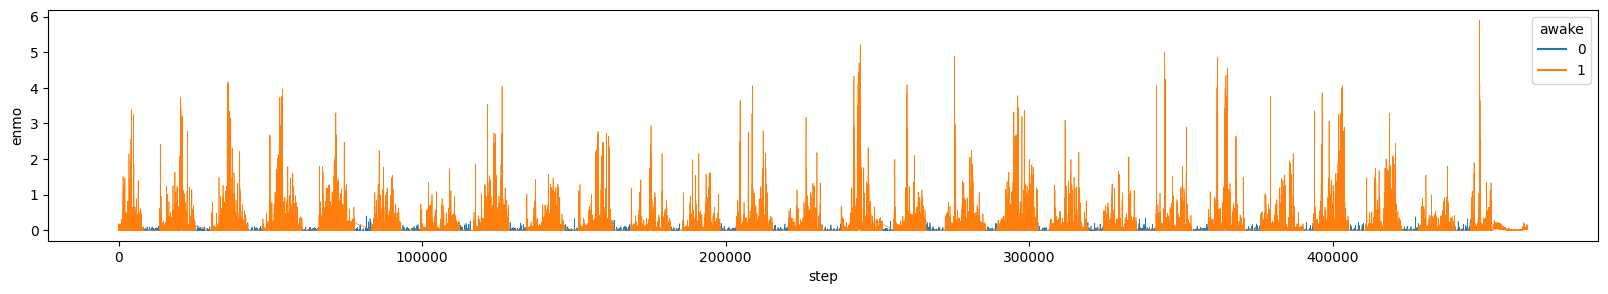

###  anglez for series 3452b878e596

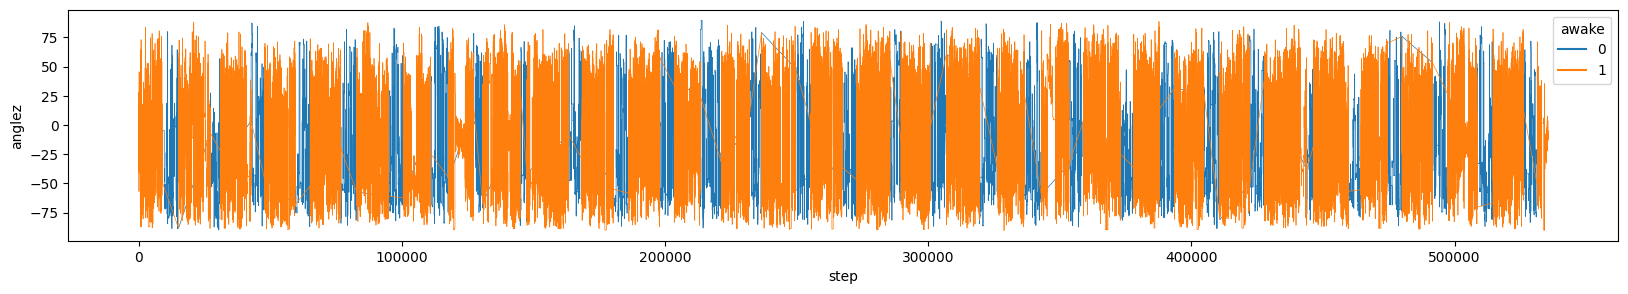

###  enmo for series 3452b878e596

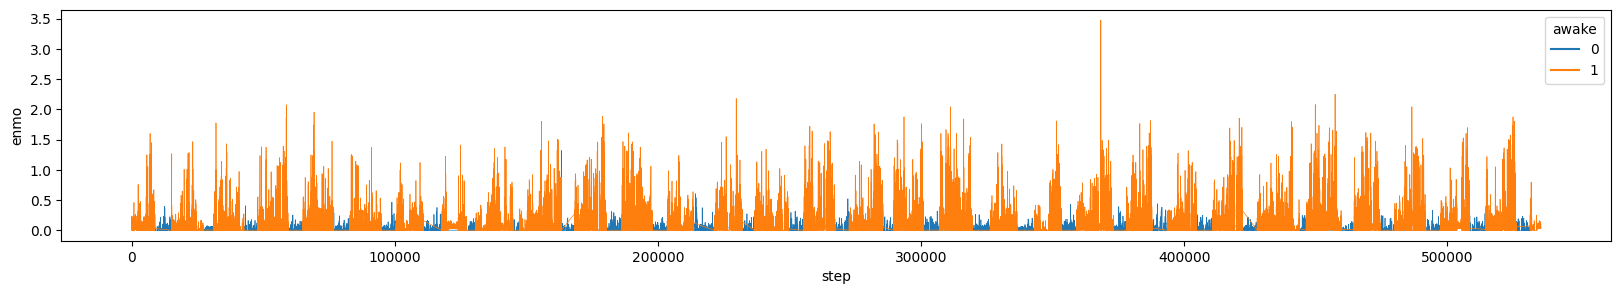

###  anglez for series 349c5562ee2c

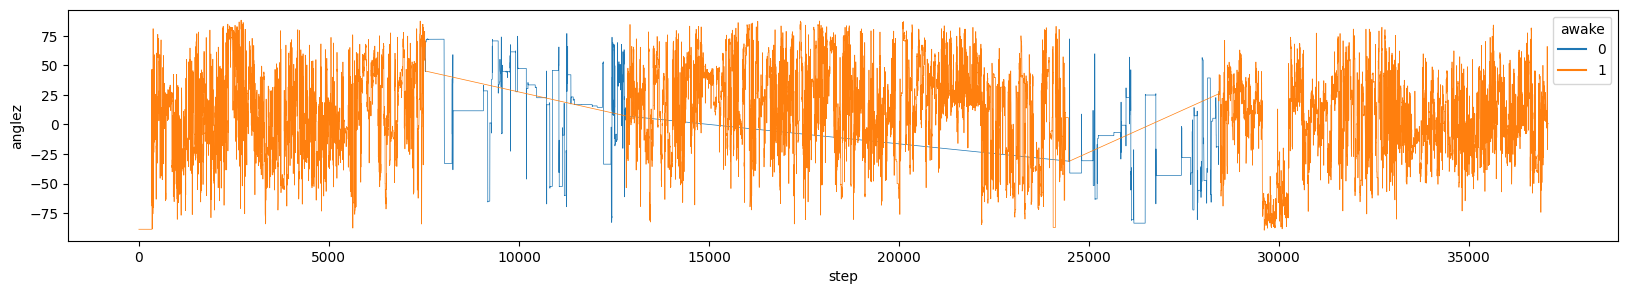

###  enmo for series 349c5562ee2c

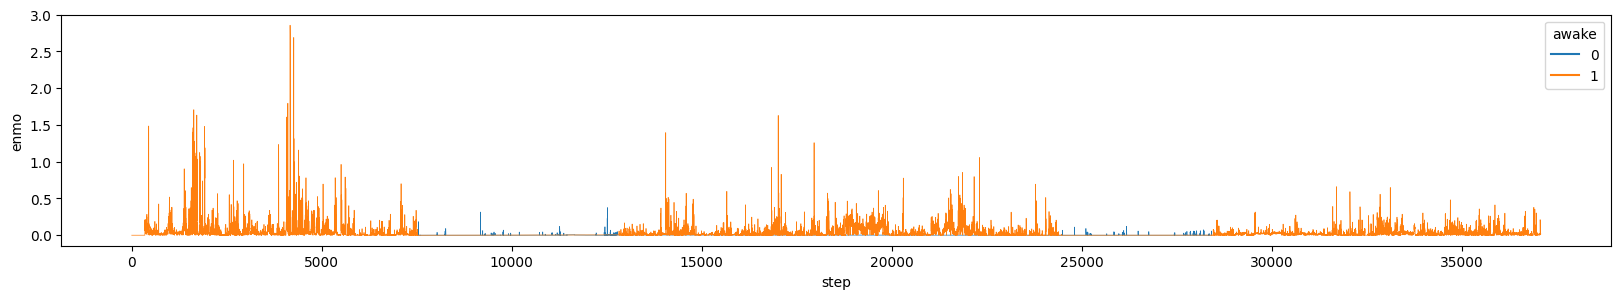

###  anglez for series 3664fe9233f9

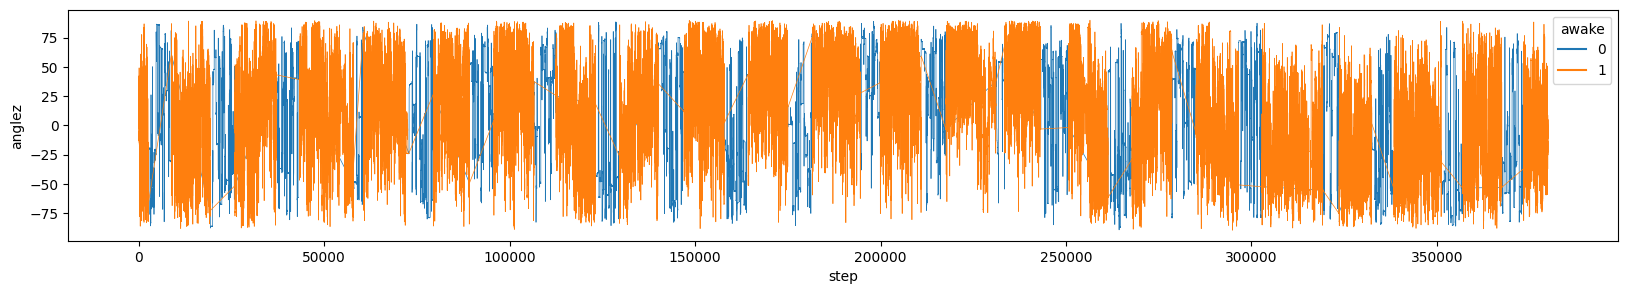

###  enmo for series 3664fe9233f9

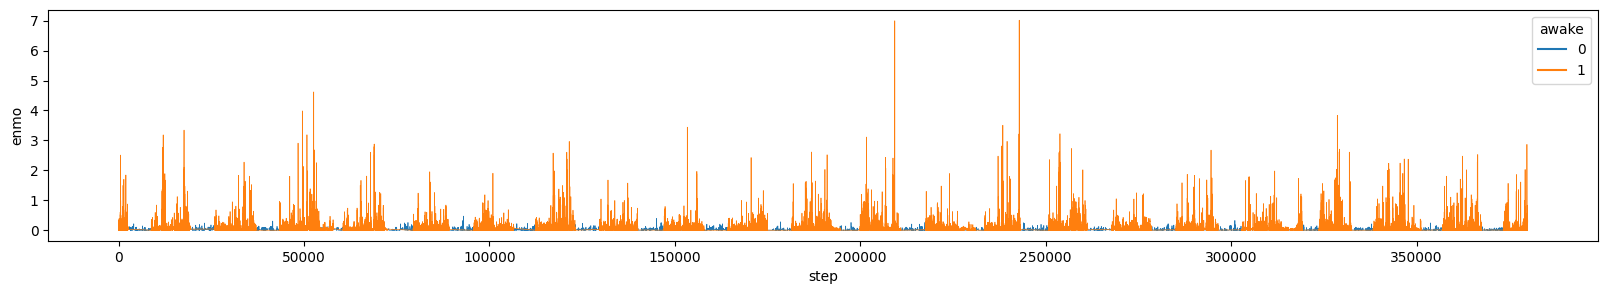

###  anglez for series 483d6545417f

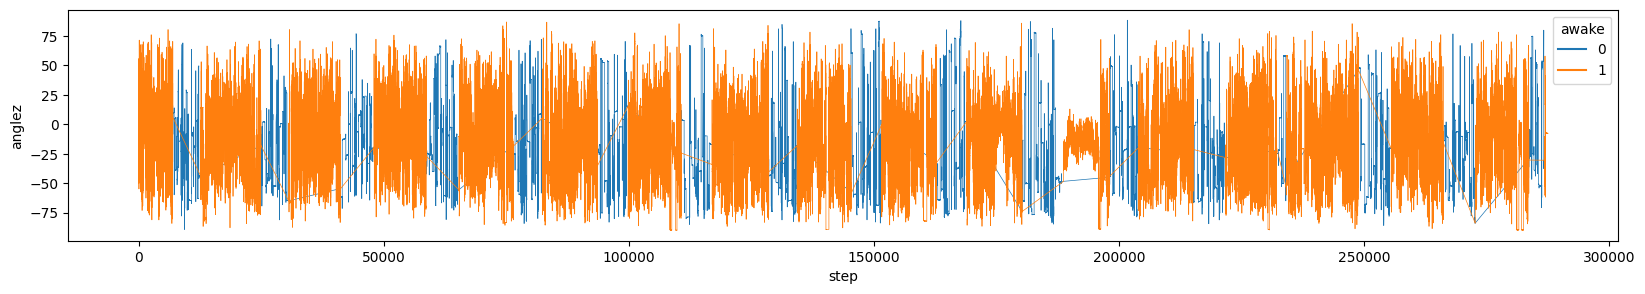

###  enmo for series 483d6545417f

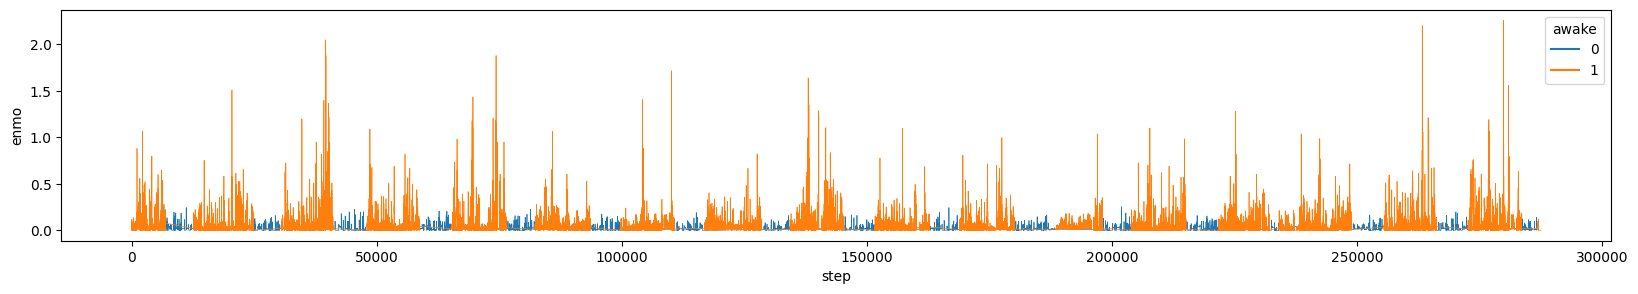

###  anglez for series 55a47ff9dc8a

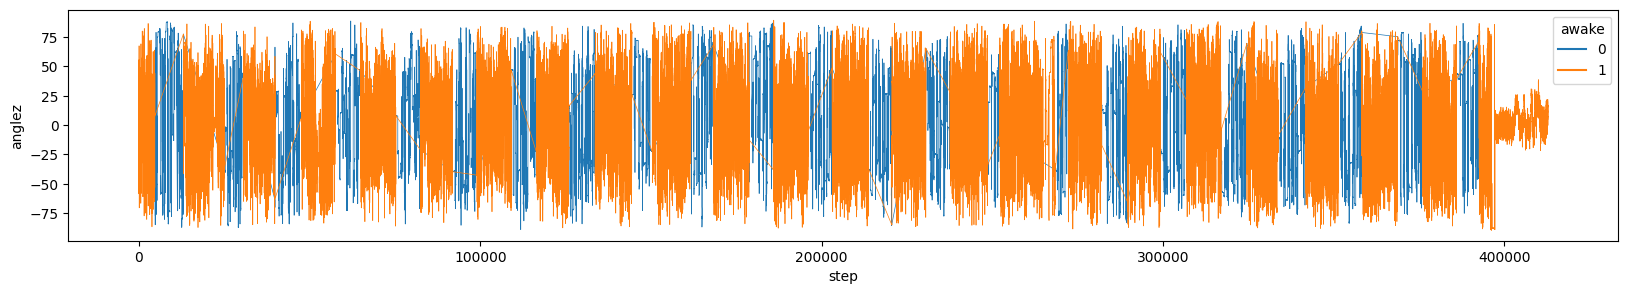

###  enmo for series 55a47ff9dc8a

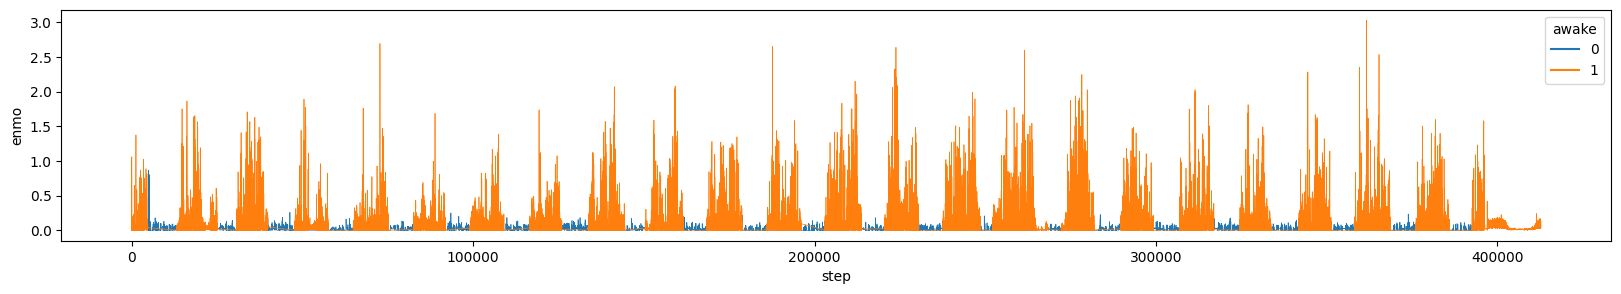

###  anglez for series 5acc9d63b5fd

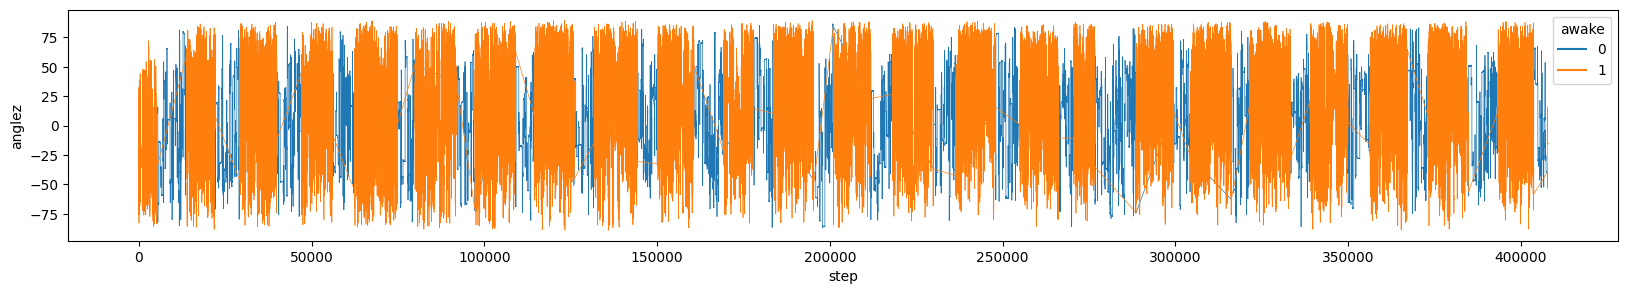

###  enmo for series 5acc9d63b5fd

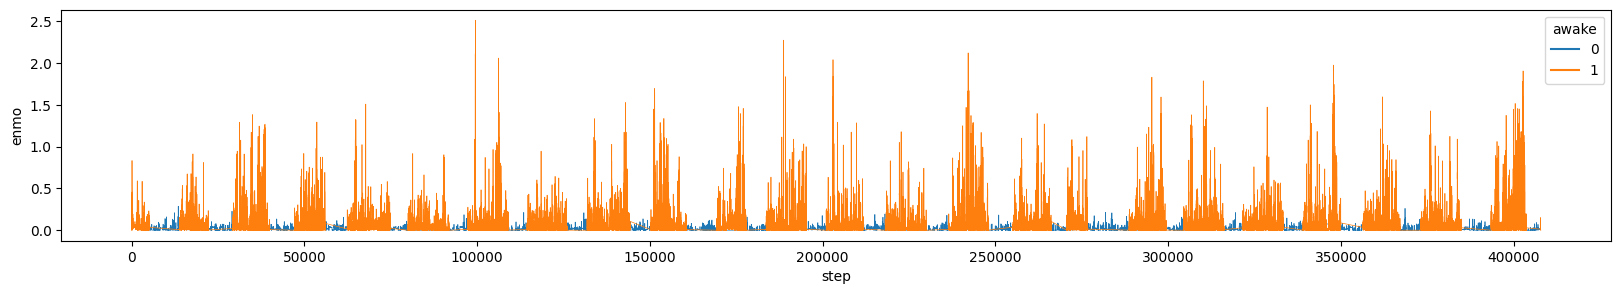

###  anglez for series 5f94bb3e1bed

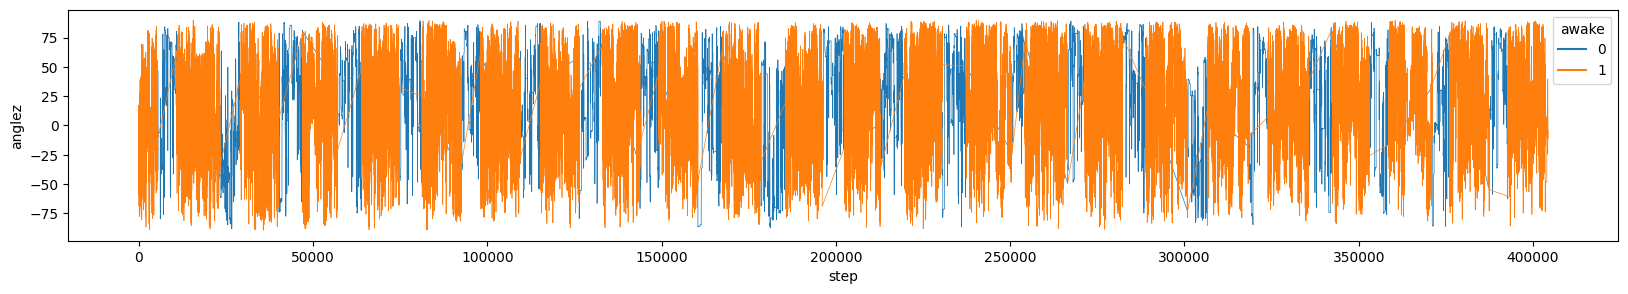

###  enmo for series 5f94bb3e1bed

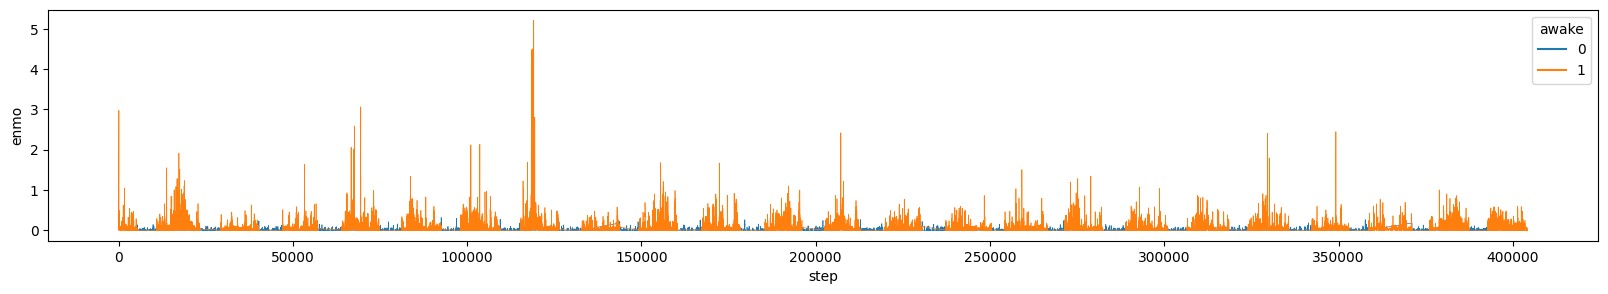

###  anglez for series 655f19eabf1e

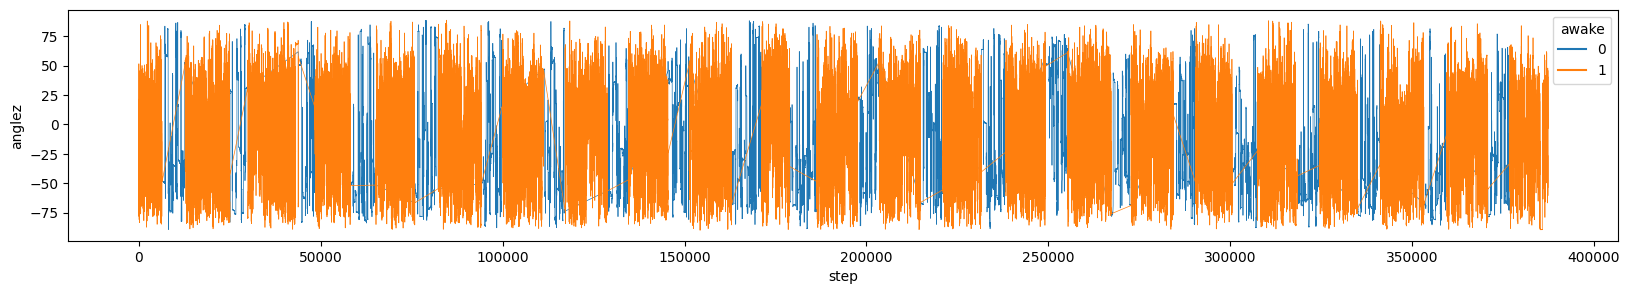

###  enmo for series 655f19eabf1e

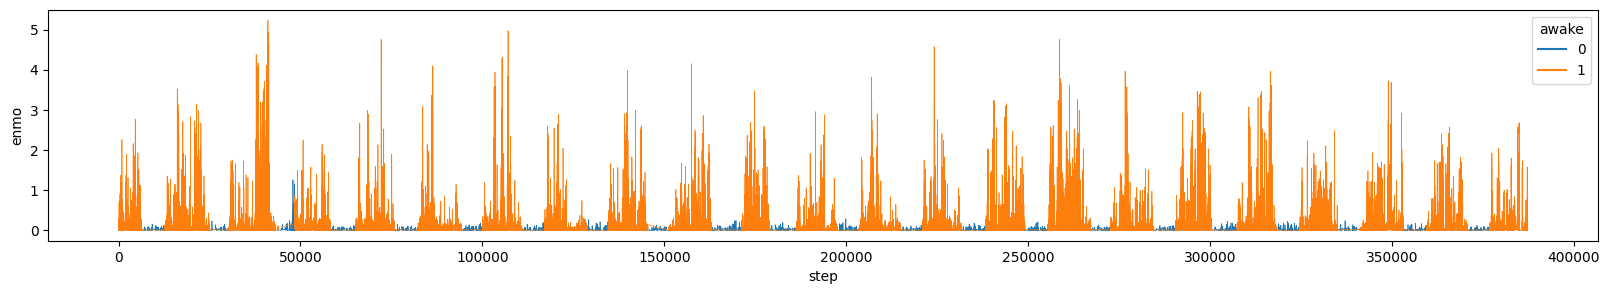

###  anglez for series 67f5fc60e494

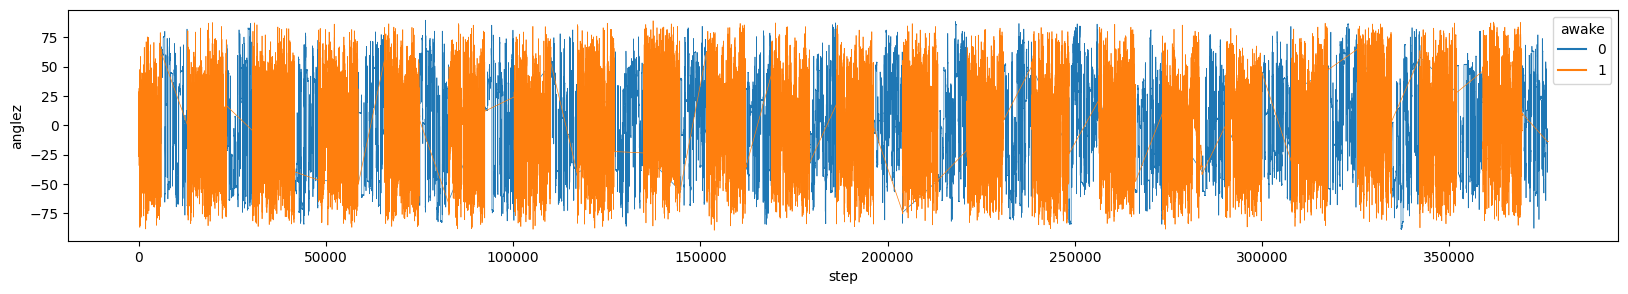

###  enmo for series 67f5fc60e494

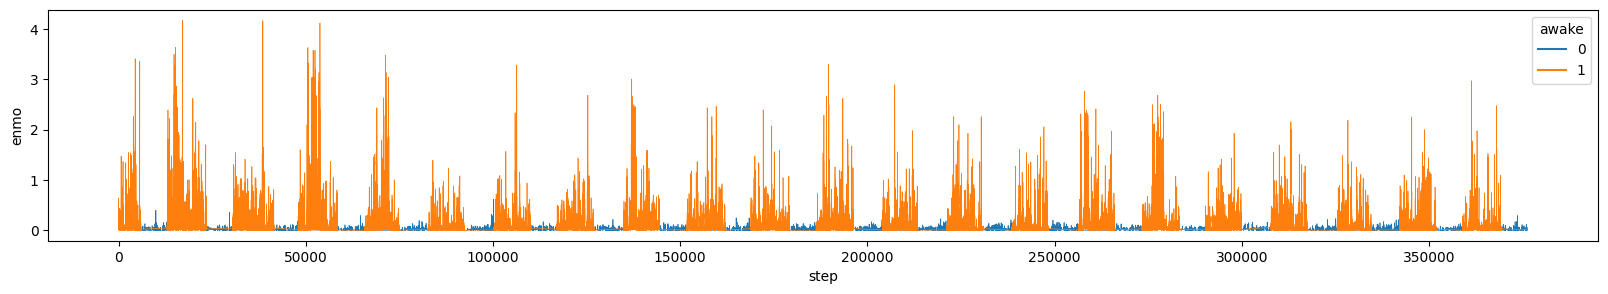

###  anglez for series 72bbd1ac3edf

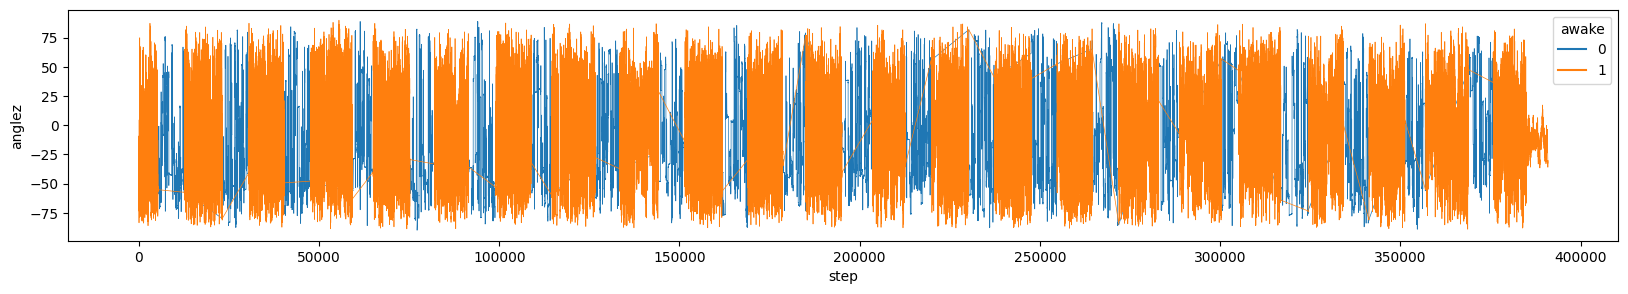

###  enmo for series 72bbd1ac3edf

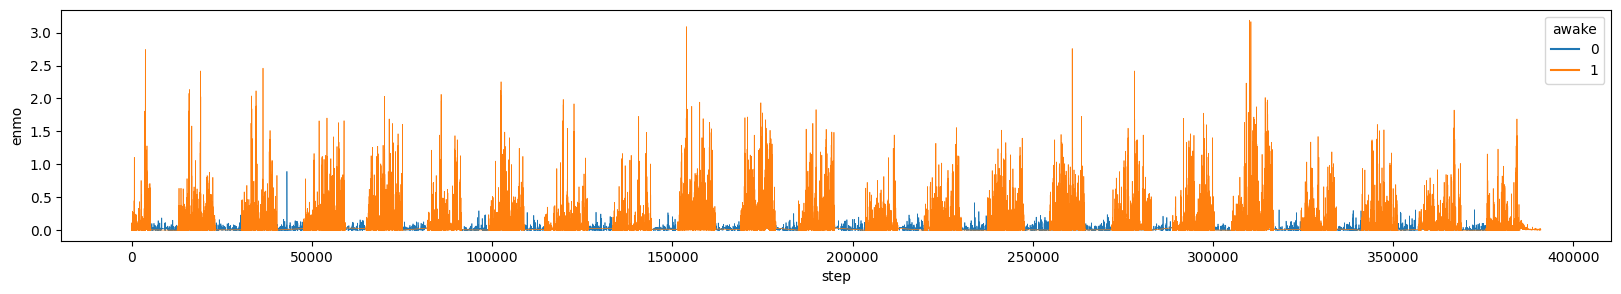

###  anglez for series 76237b9406d5

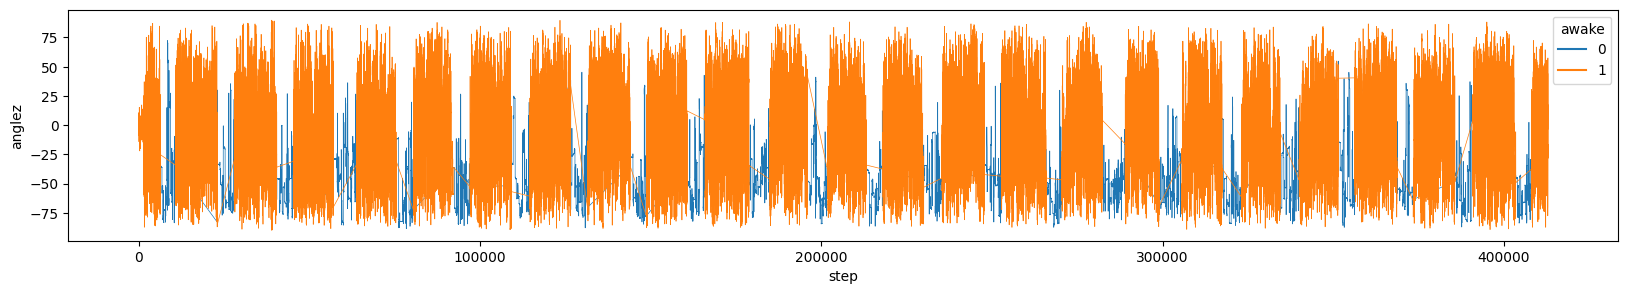

###  enmo for series 76237b9406d5

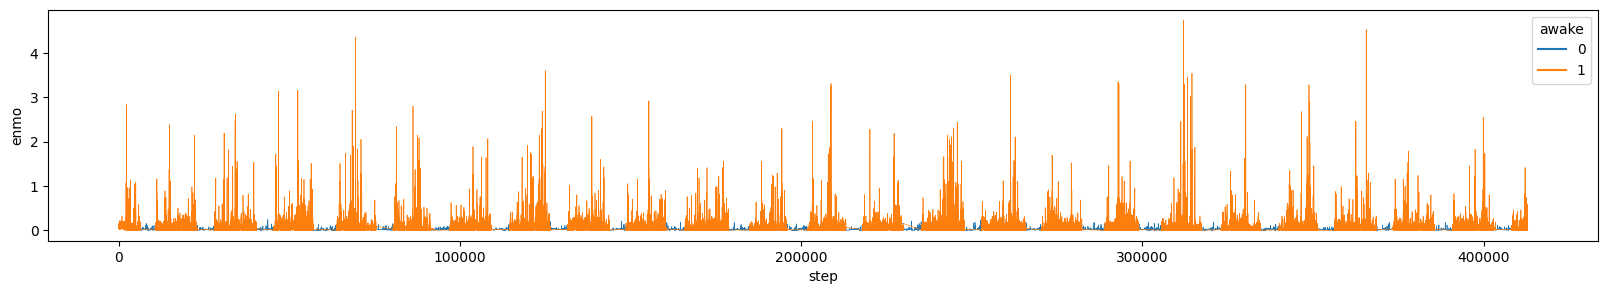

###  anglez for series 7822ee8fe3ec

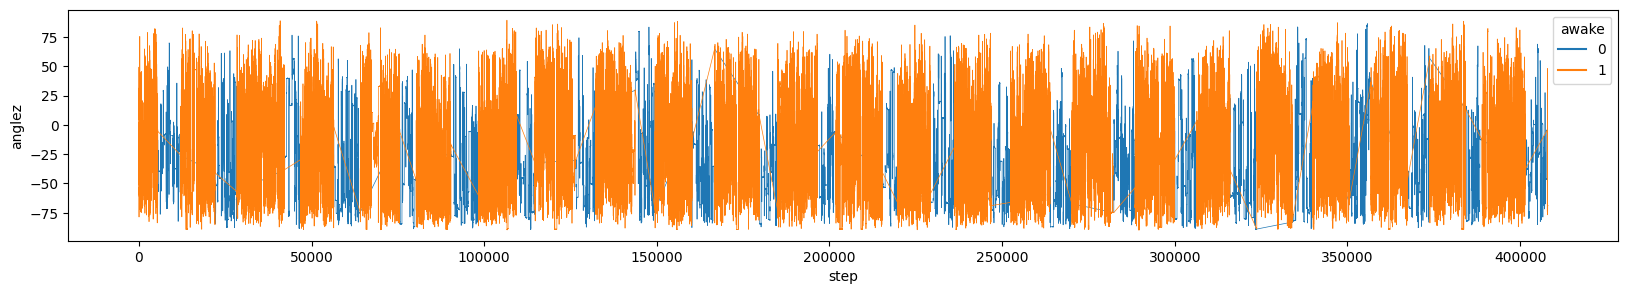

###  enmo for series 7822ee8fe3ec

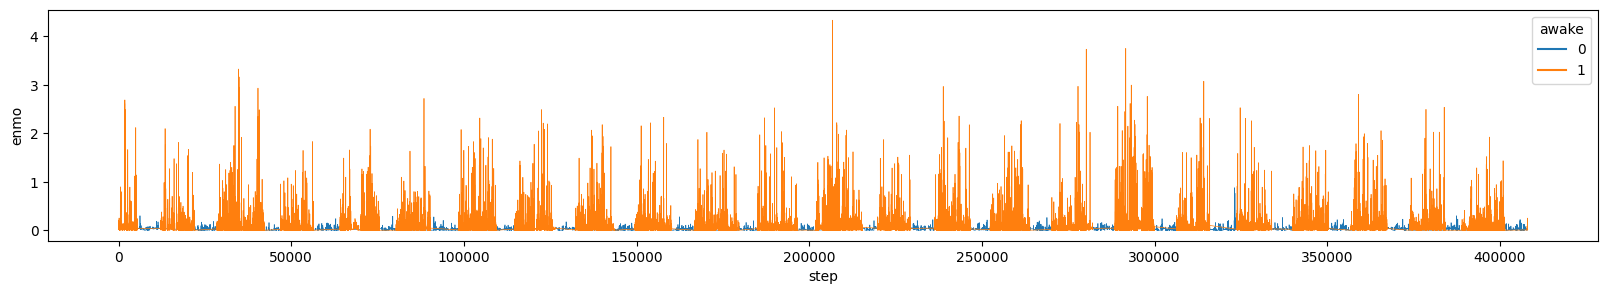

###  anglez for series 89bd631d1769

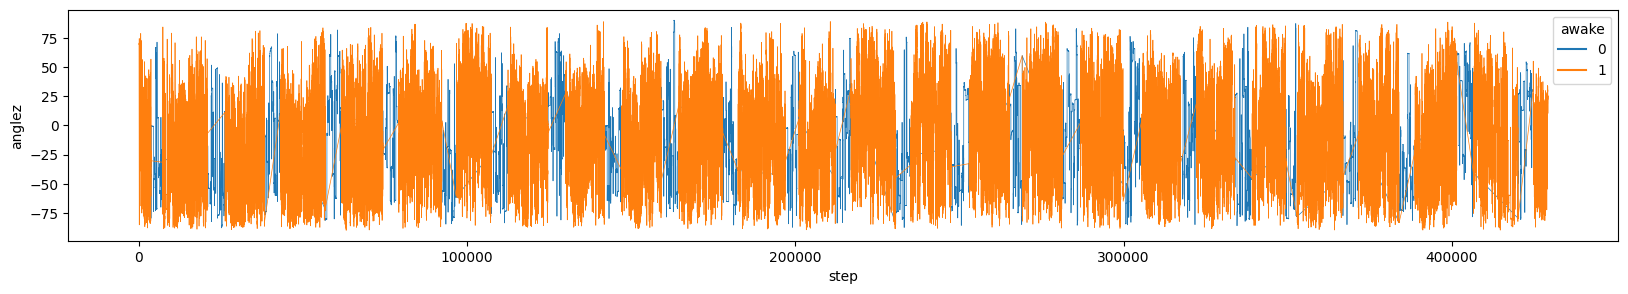

###  enmo for series 89bd631d1769

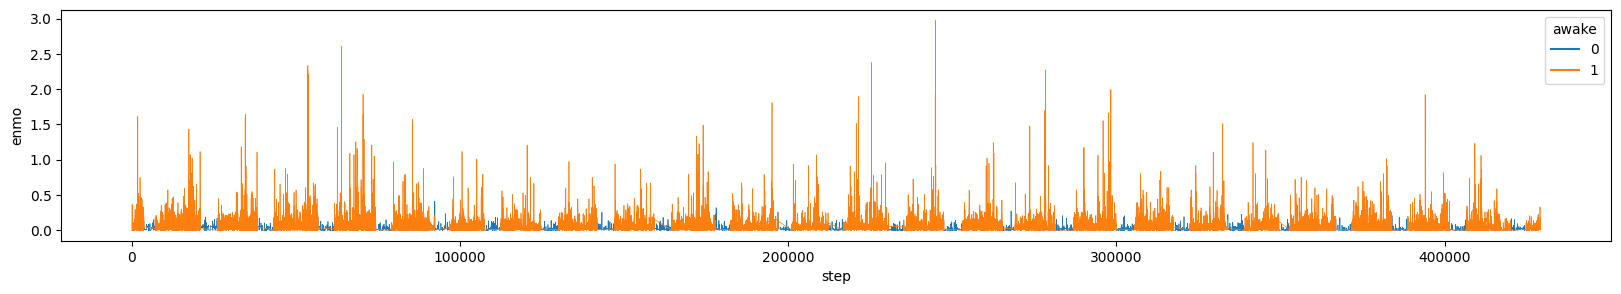

###  anglez for series 8e32047cbc1f

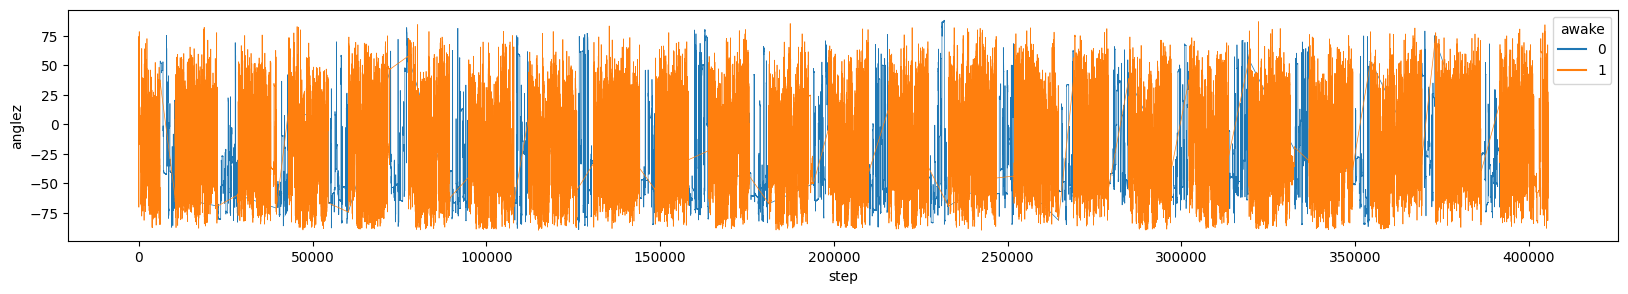

###  enmo for series 8e32047cbc1f

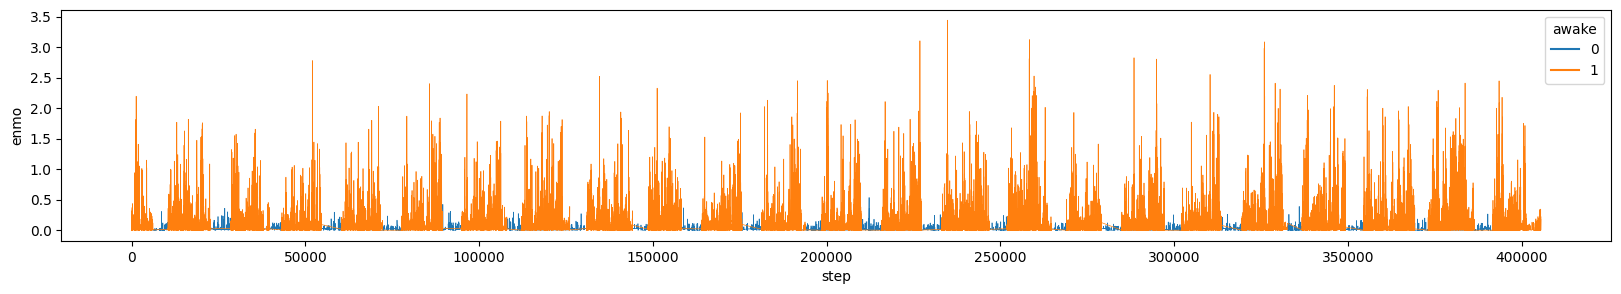

###  anglez for series 939932f1822d

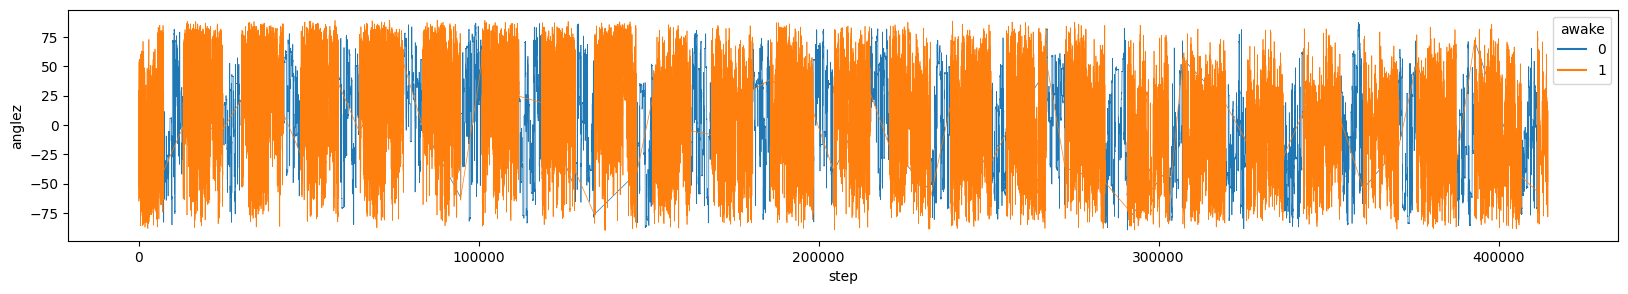

###  enmo for series 939932f1822d

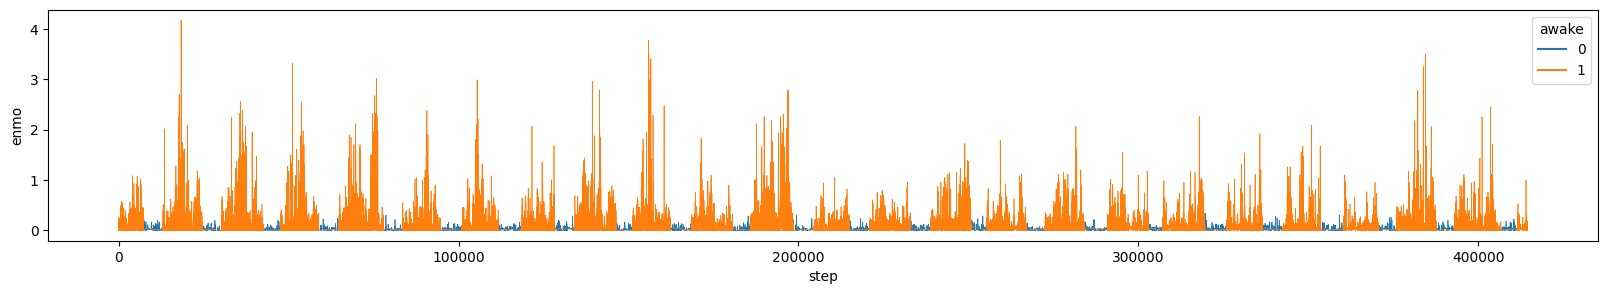

###  anglez for series 9ee455e4770d

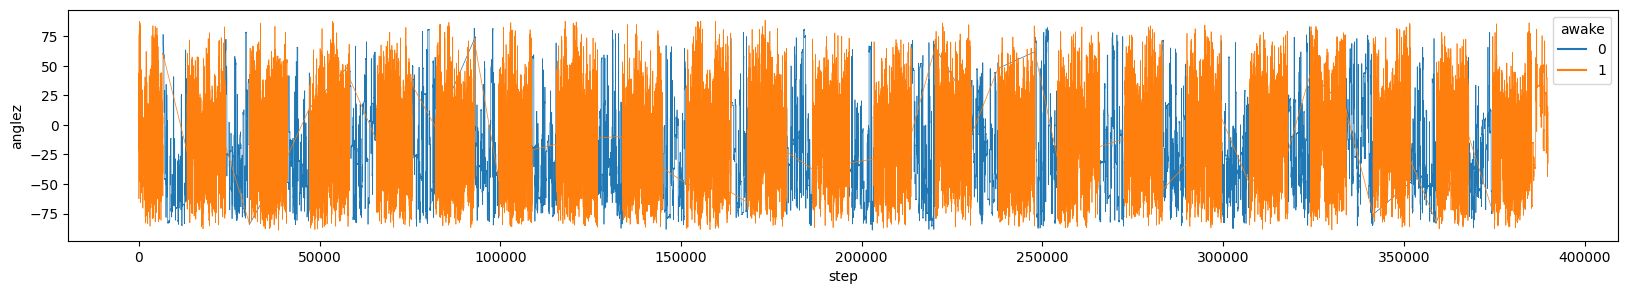

###  enmo for series 9ee455e4770d

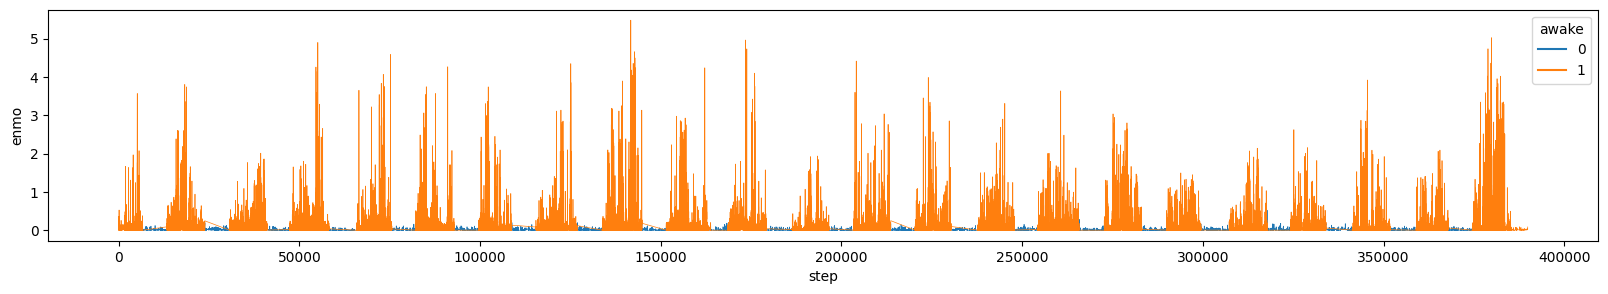

###  anglez for series a9a2f7fac455

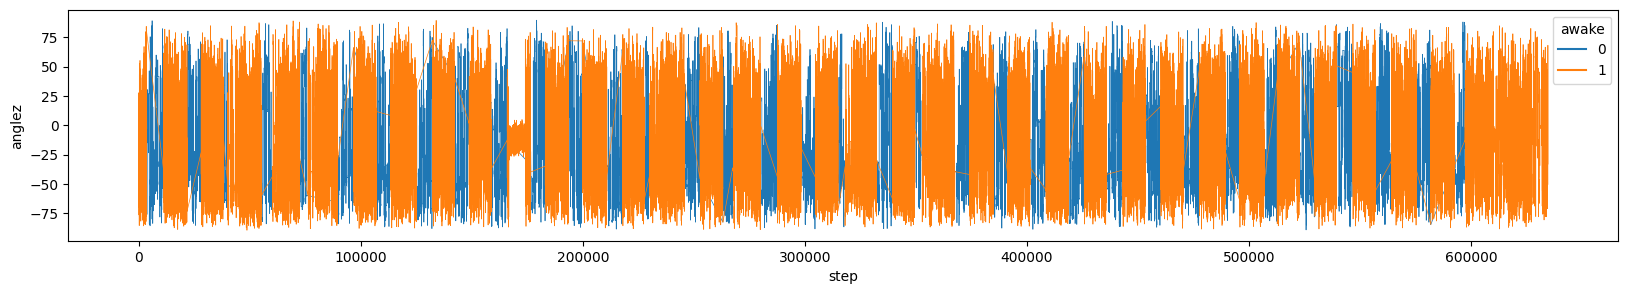

###  enmo for series a9a2f7fac455

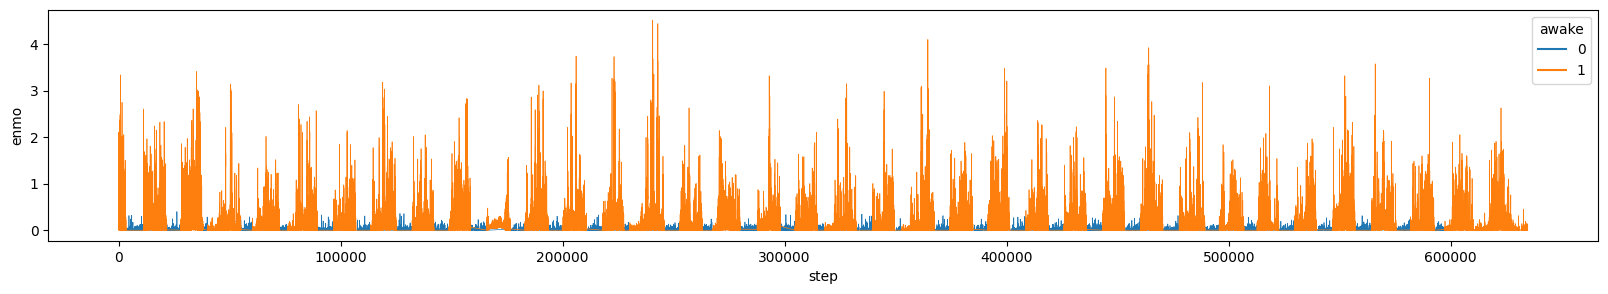

###  anglez for series a9e5f5314bcb

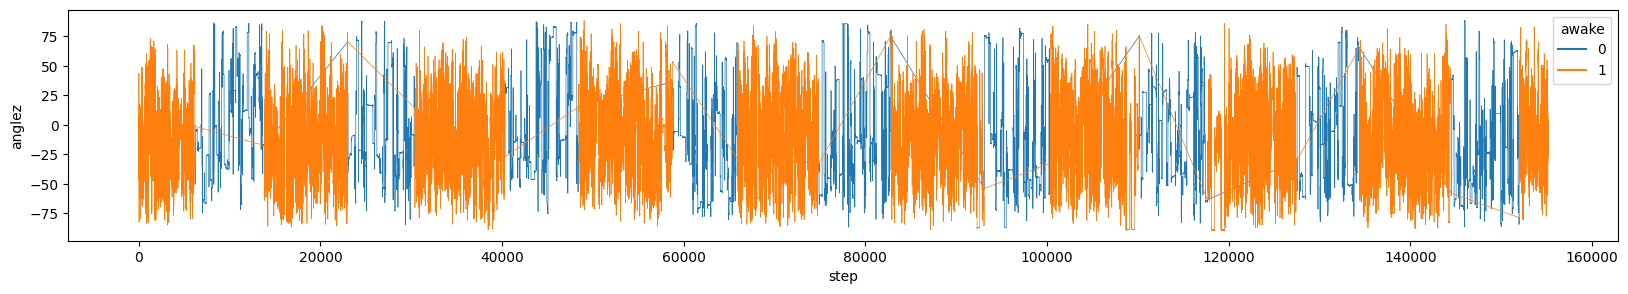

###  enmo for series a9e5f5314bcb

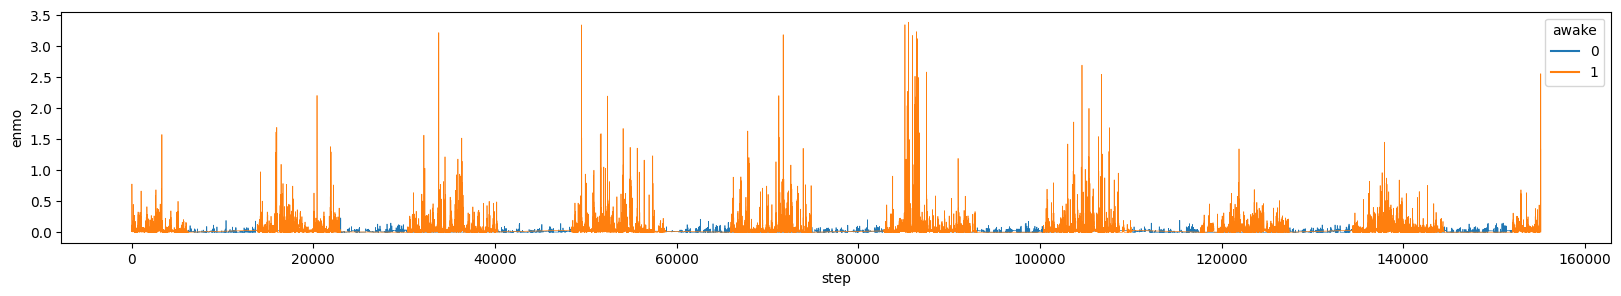

###  anglez for series af91d9a50547

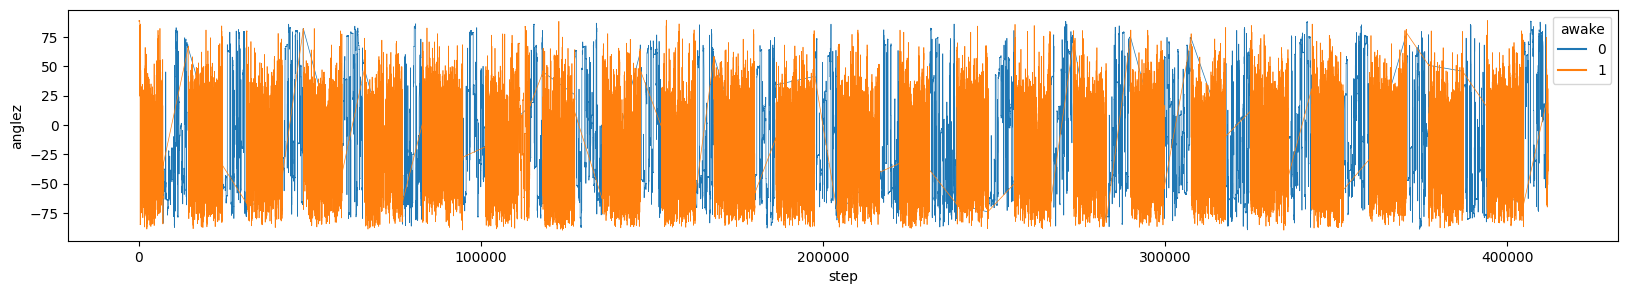

###  enmo for series af91d9a50547

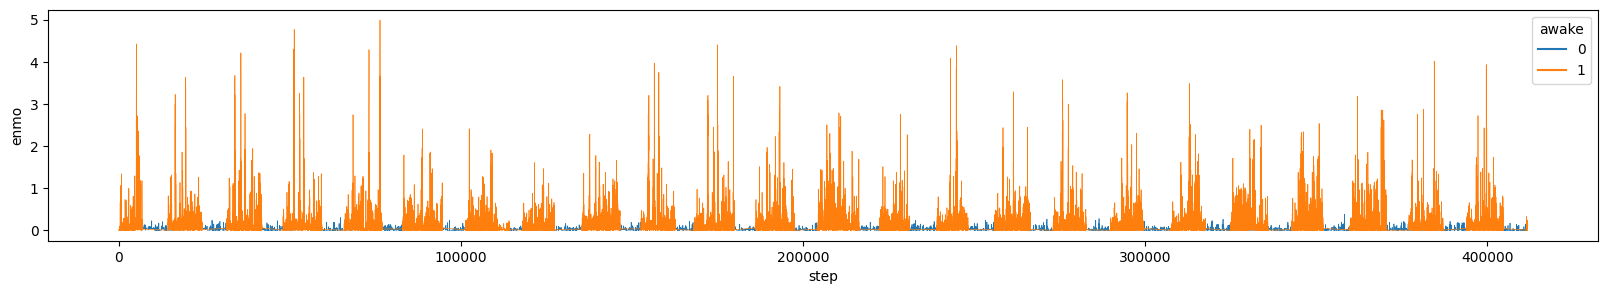

###  anglez for series b364205aba43

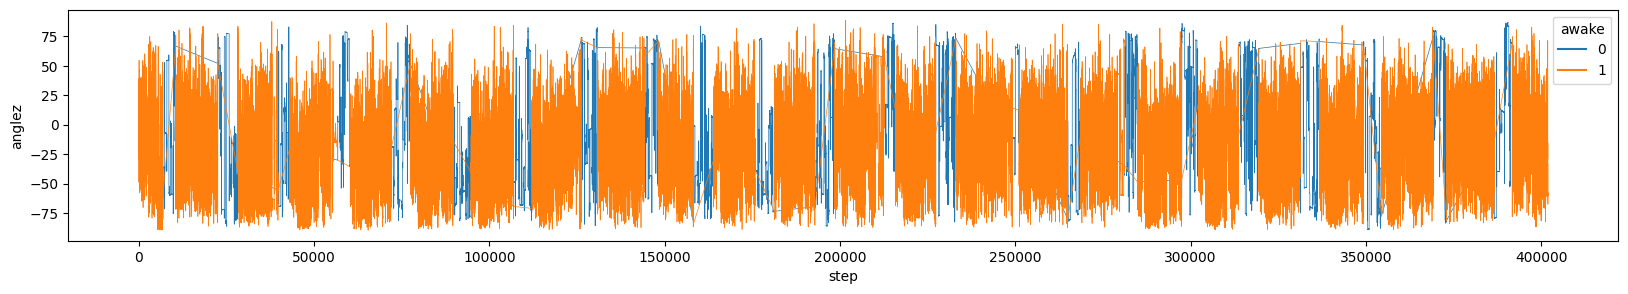

###  enmo for series b364205aba43

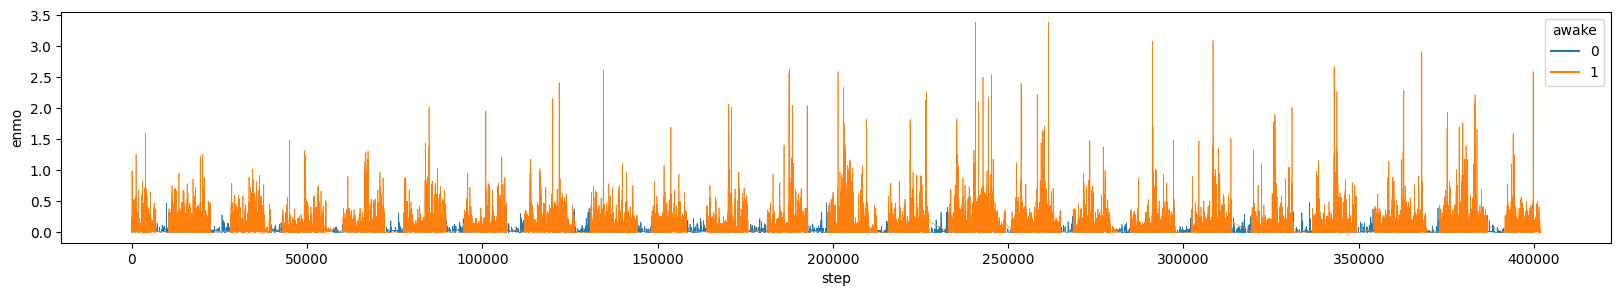

###  anglez for series c535634d7dcd

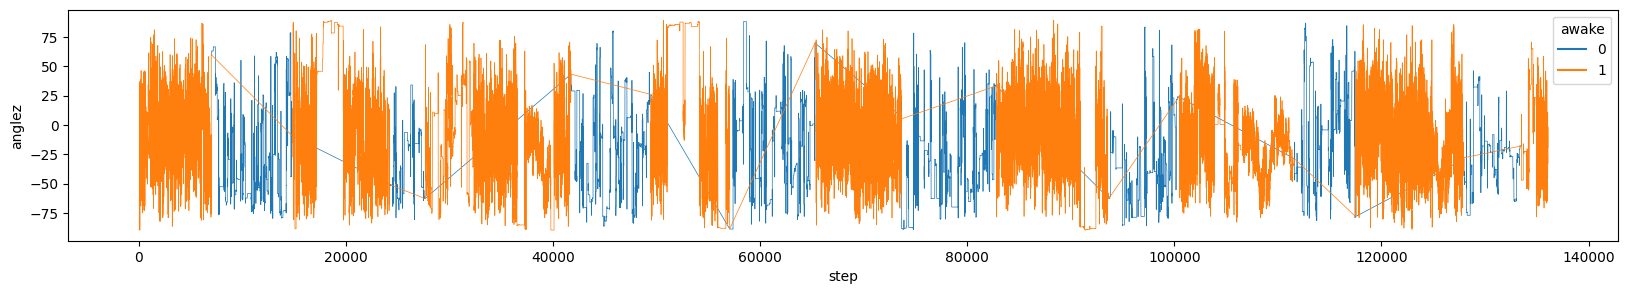

###  enmo for series c535634d7dcd

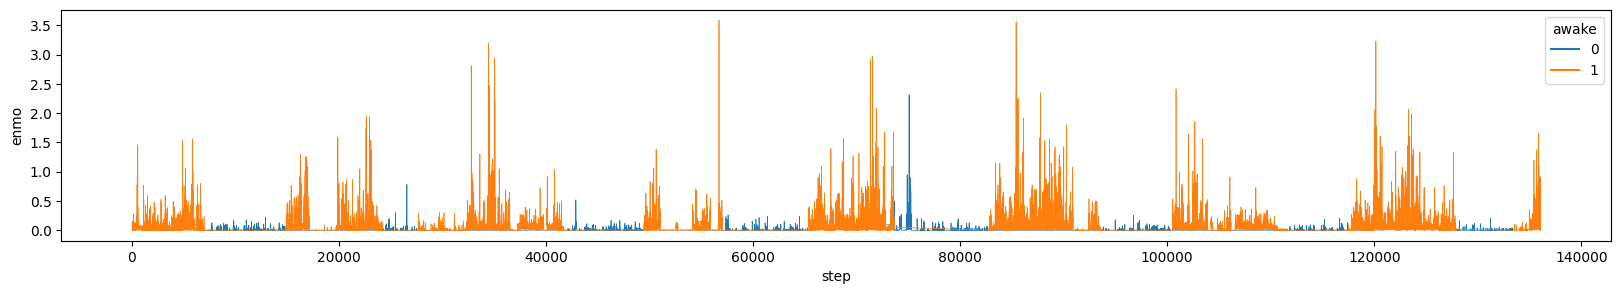

###  anglez for series c6788e579967

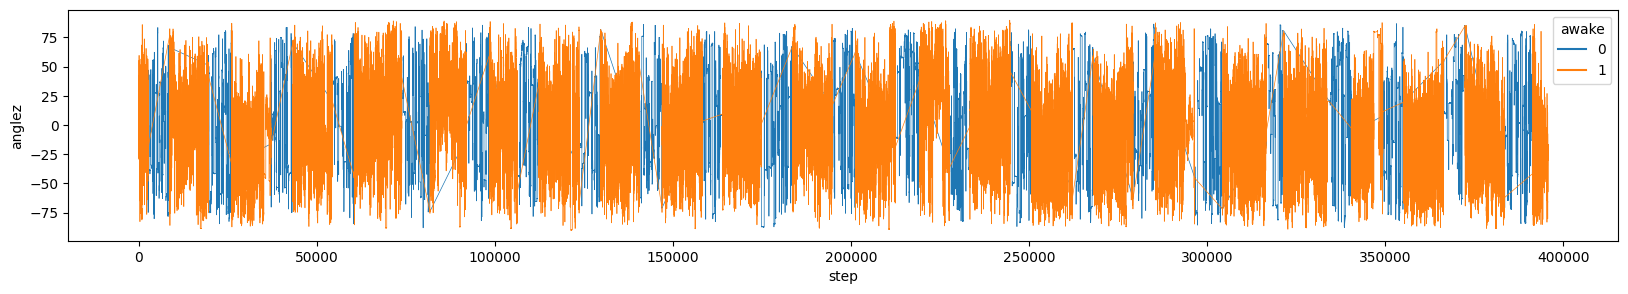

###  enmo for series c6788e579967

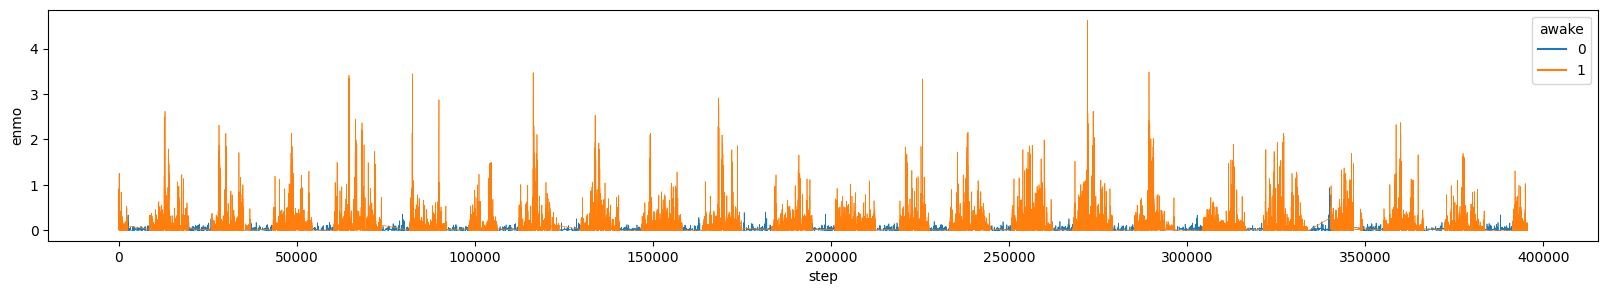

###  anglez for series c68260cc9e8f

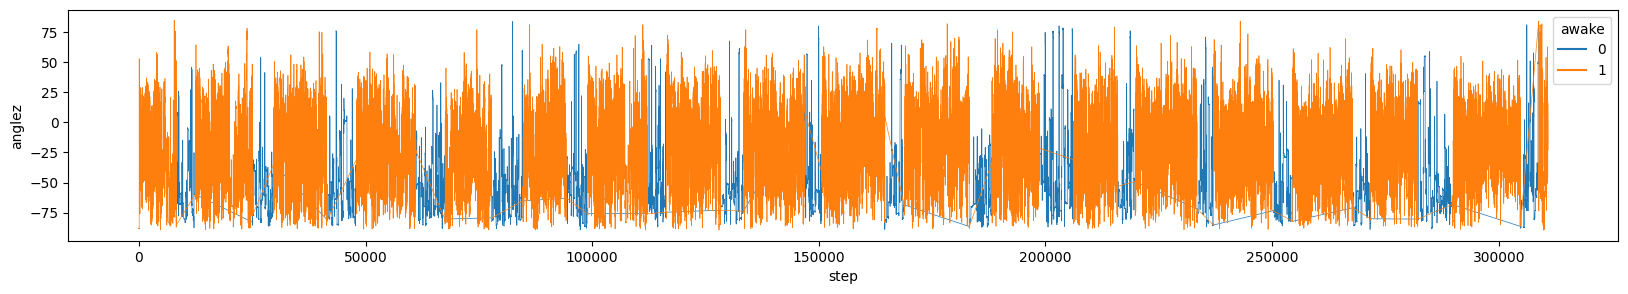

###  enmo for series c68260cc9e8f

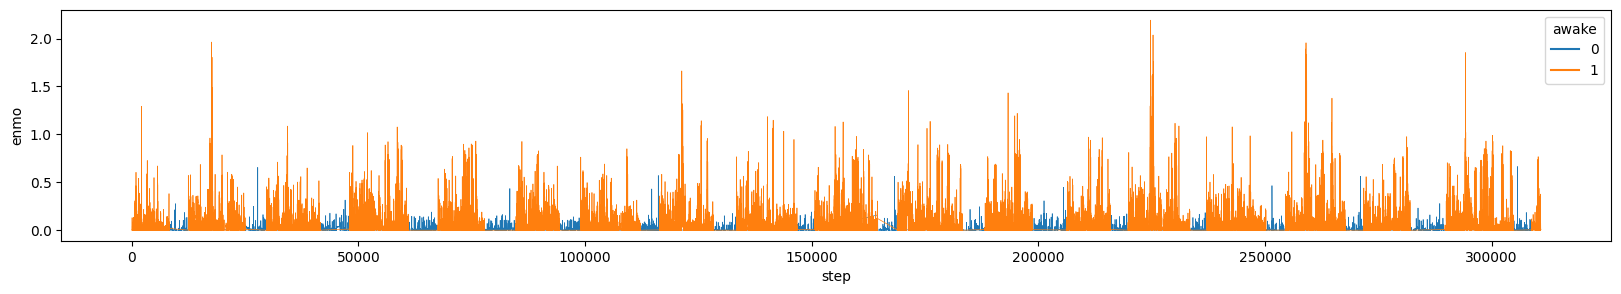

###  anglez for series ca730dbf521d

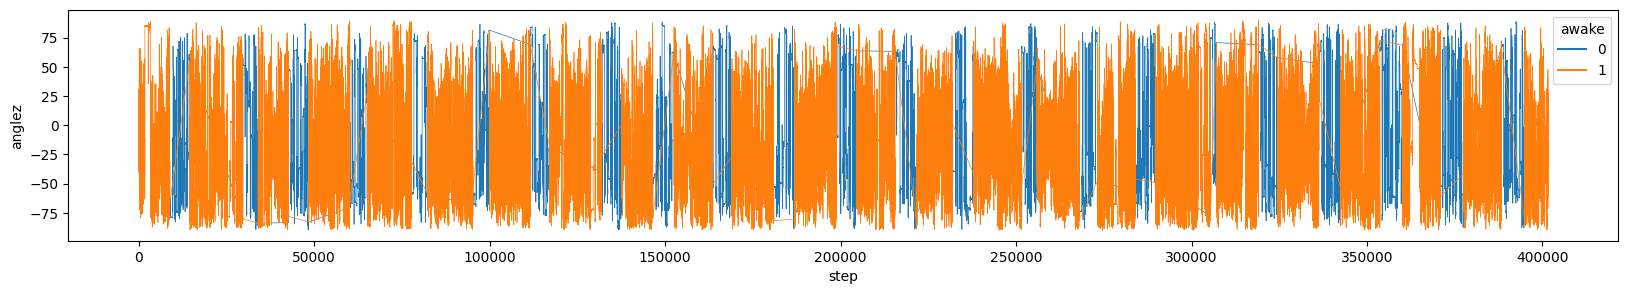

###  enmo for series ca730dbf521d

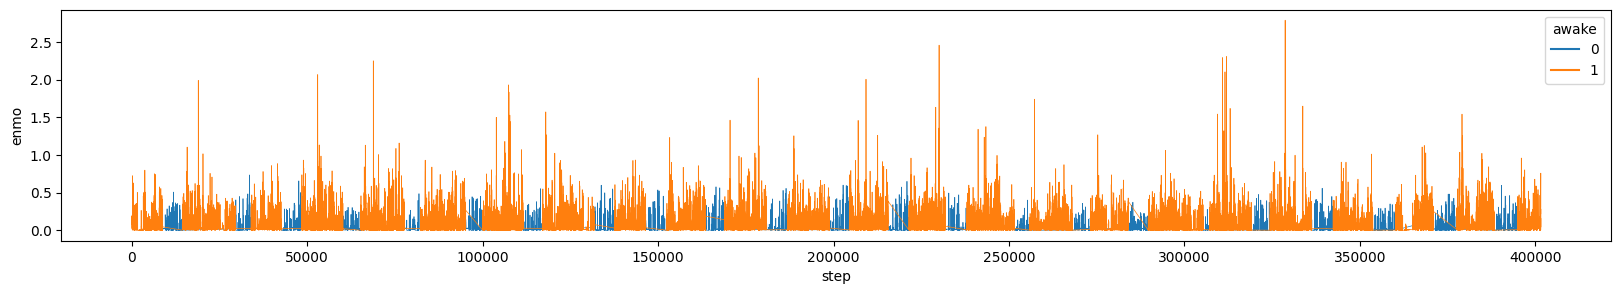

###  anglez for series d150801f3145

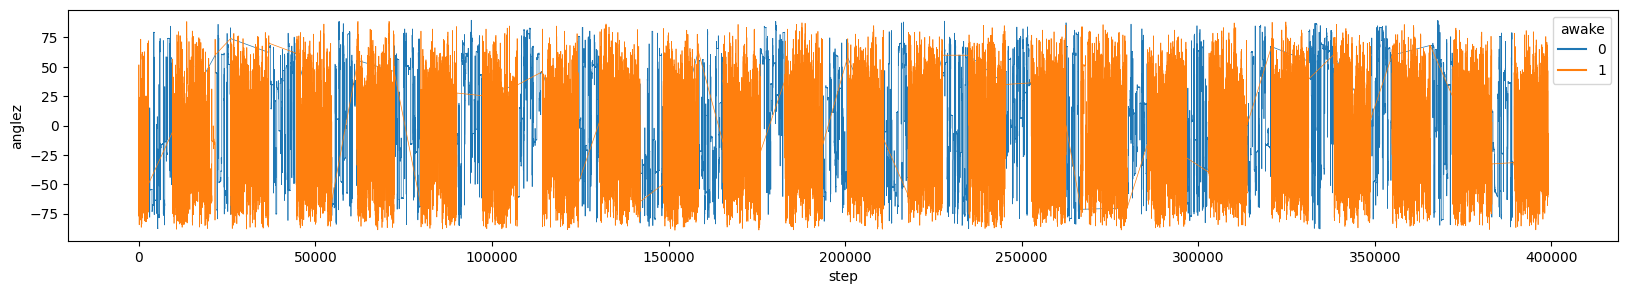

###  enmo for series d150801f3145

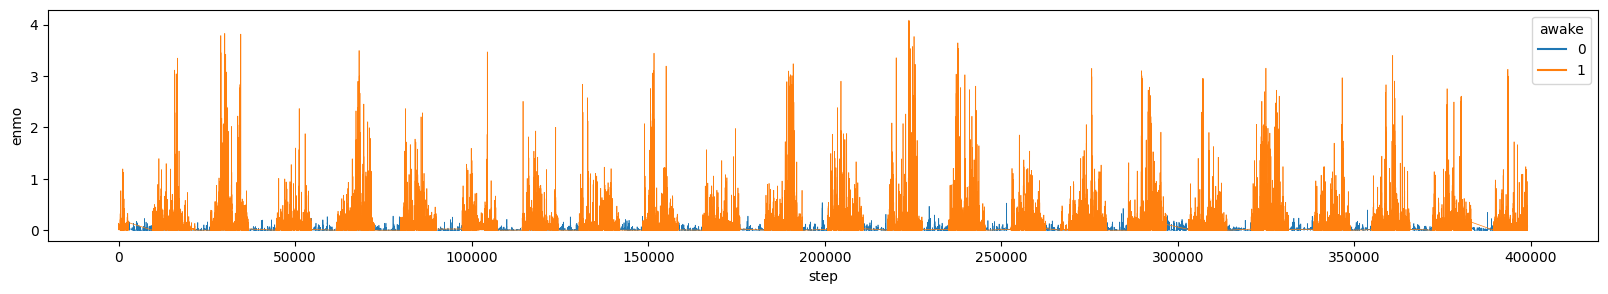

###  anglez for series d25e479ecbb7

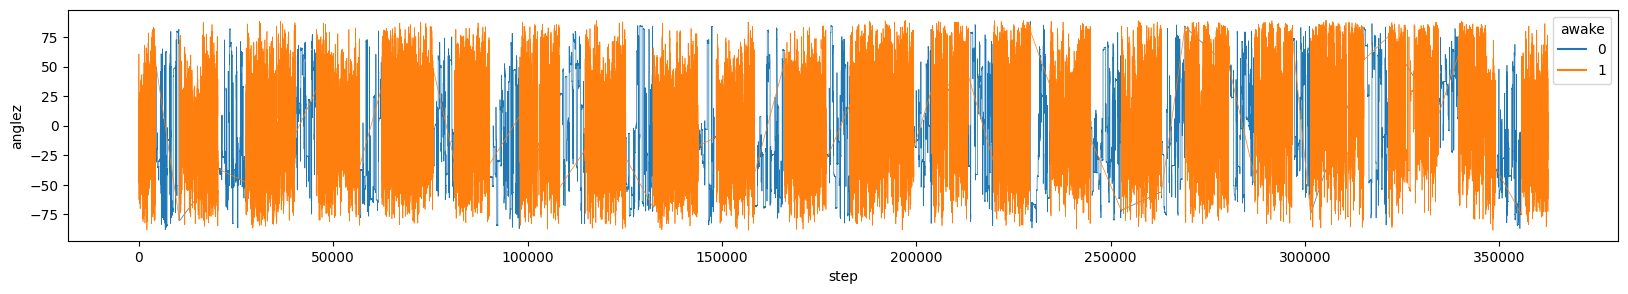

###  enmo for series d25e479ecbb7

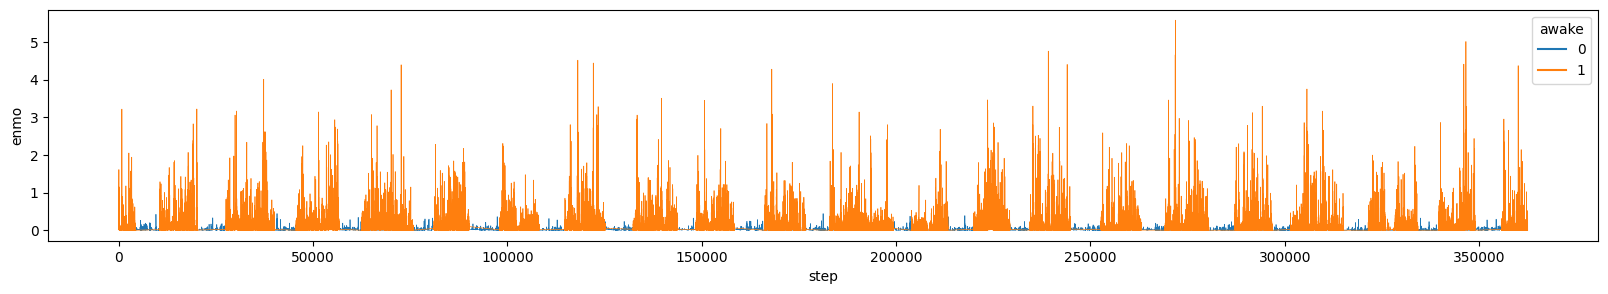

###  anglez for series d515236bdeec

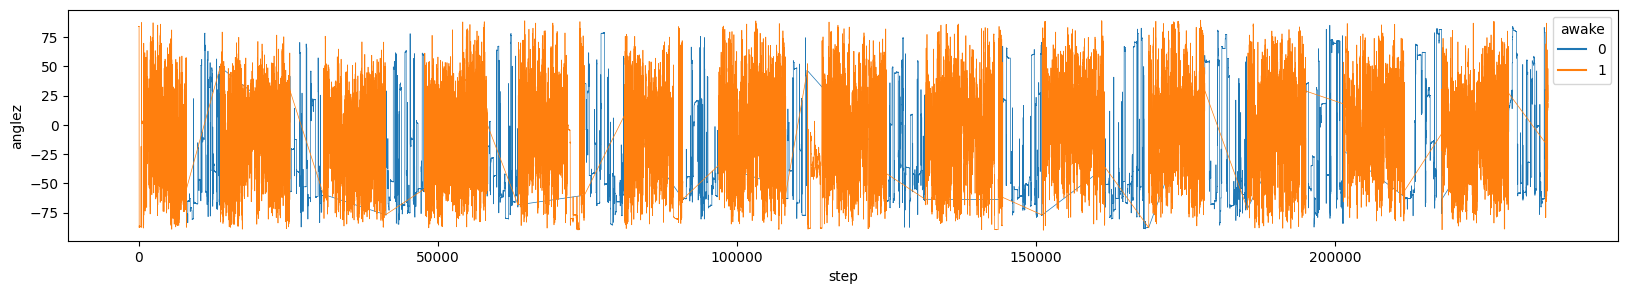

###  enmo for series d515236bdeec

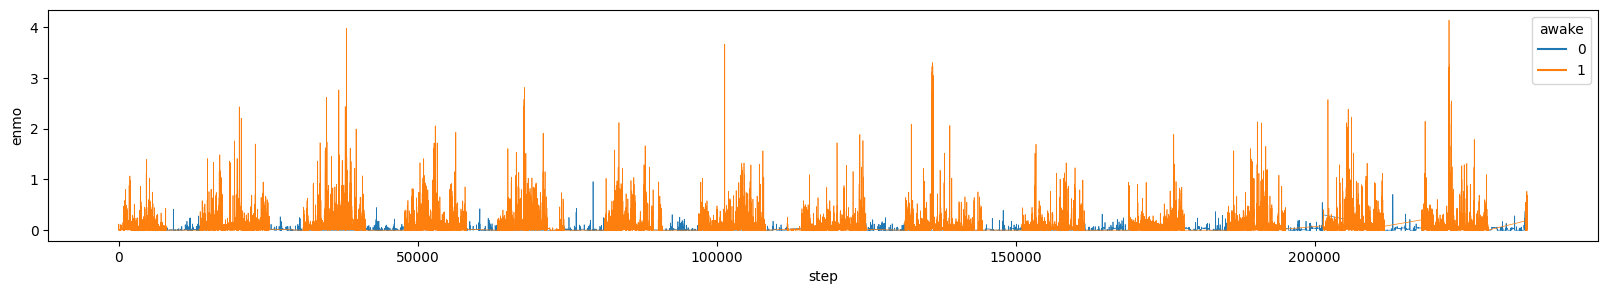

###  anglez for series d5e47b94477e

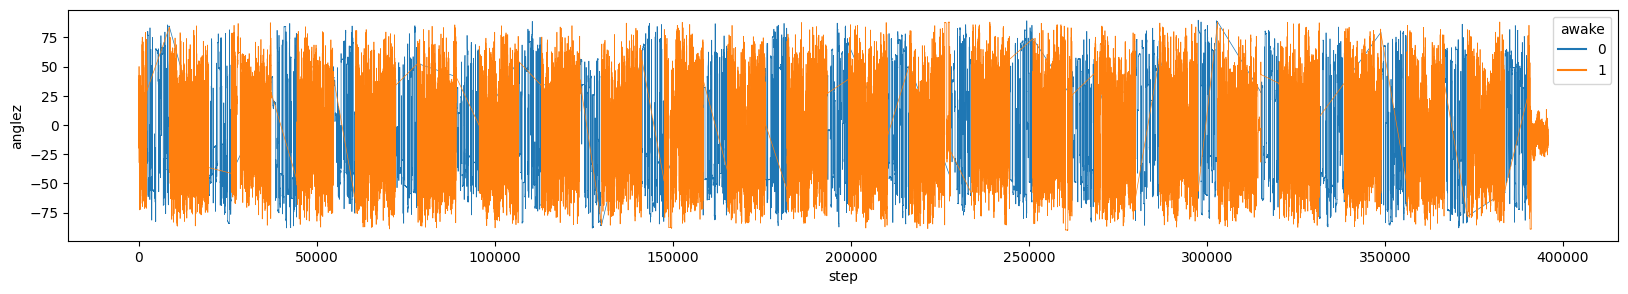

###  enmo for series d5e47b94477e

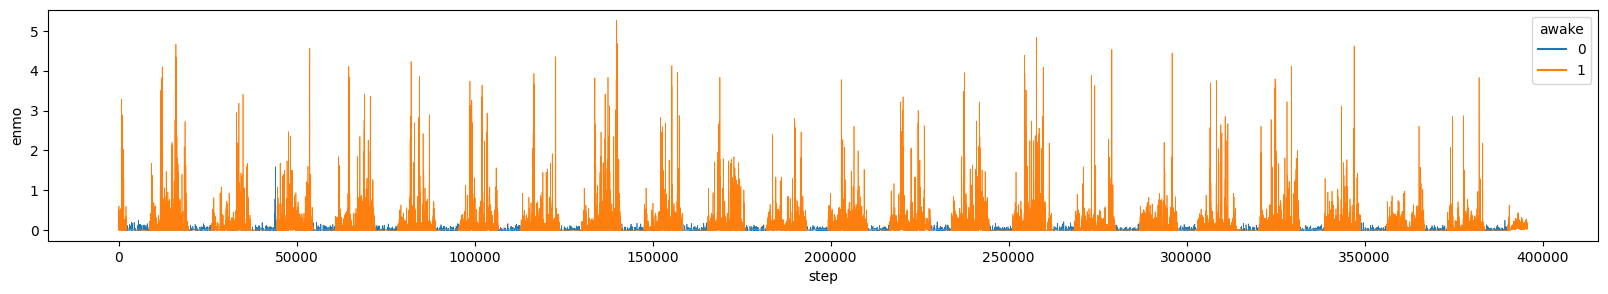

In [19]:
smaller_train_data = []

for series_id in no_nan_series:
    train = get_train_series(series_id)
    smaller_train_data.append(train)
    
    # vizualize these series
    display(Markdown('###  anglez for series ' + series_id))
    fig, ax = plt.subplots(figsize=(20, 3))
    sns.lineplot(data=train, x="step", y="anglez",hue="awake", linewidth = 0.5)
    plt.show();
    display(Markdown('###  enmo for series ' + series_id))
    fig, ax = plt.subplots(figsize=(20, 3))
    sns.lineplot(data=train, x="step", y="enmo",hue="awake", linewidth = 0.5)
    plt.show();
    del train
    gc.collect();

## The blue represents sleep states and the orange represents awake states. Looking at the enmo graphs in particular, we can see that there is an obvious difference between the average angular acceleration between sleep and awake states. We can see how a machine learning algorithm might be able to discern these changes.

In [20]:
new_train = pd.concat(smaller_train_data).reset_index(drop=True)
new_train["series_id"].nunique()

35

In [21]:
new_train

series_id    step                 timestamp     anglez    enmo  \
0         08db4255286f       0  2018-11-05T10:00:00-0400 -30.845301  0.0447   
1         08db4255286f       1  2018-11-05T10:00:05-0400 -34.181801  0.0443   
2         08db4255286f       2  2018-11-05T10:00:10-0400 -33.877102  0.0483   
3         08db4255286f       3  2018-11-05T10:00:15-0400 -34.282101  0.0680   
4         08db4255286f       4  2018-11-05T10:00:20-0400 -34.385799  0.0768   
...                ...     ...                       ...        ...     ...   
13165555  d5e47b94477e  395815  2017-12-02T15:44:35-0500 -10.064100  0.1552   
13165556  d5e47b94477e  395816  2017-12-02T15:44:40-0500 -10.006700  0.1139   
13165557  d5e47b94477e  395817  2017-12-02T15:44:45-0500  -3.328600  0.1245   
13165558  d5e47b94477e  395818  2017-12-02T15:44:50-0500  -5.903100  0.1363   
13165559  d5e47b94477e  395819  2017-12-02T15:44:55-0500 -11.691100  0.0995   

          awake  
0             1  
1             1  
2             1  
3             1  
4             1  
...         ...  
13165555      1  
13165556      1  
13165557      1  
13165558      1  
13165559      1  

[13165560 rows x 6 columns]

### ^^^ We created this beautiful dataset!

--------------
# 3 Preliminary Statistical Analysis

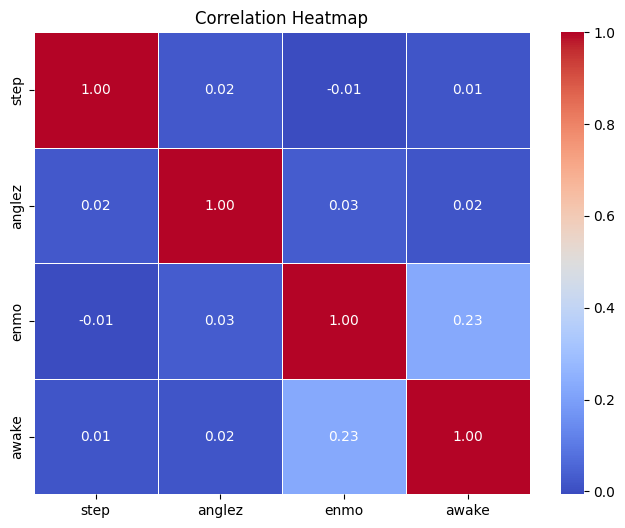

In [22]:
plt.figure(figsize=(8, 6)) 
sns.heatmap(new_train.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.title('Correlation Heatmap')
plt.show()

## We can see some okay-ish correlation between enmo and awake, but nothing substantial anywhere else. We will probably have to use more sophisticated/nonlinear machine learning models here

### Lets just look at the autocorrelation plot of one series' enmo data (since this dataset is huge, even after the reduction)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

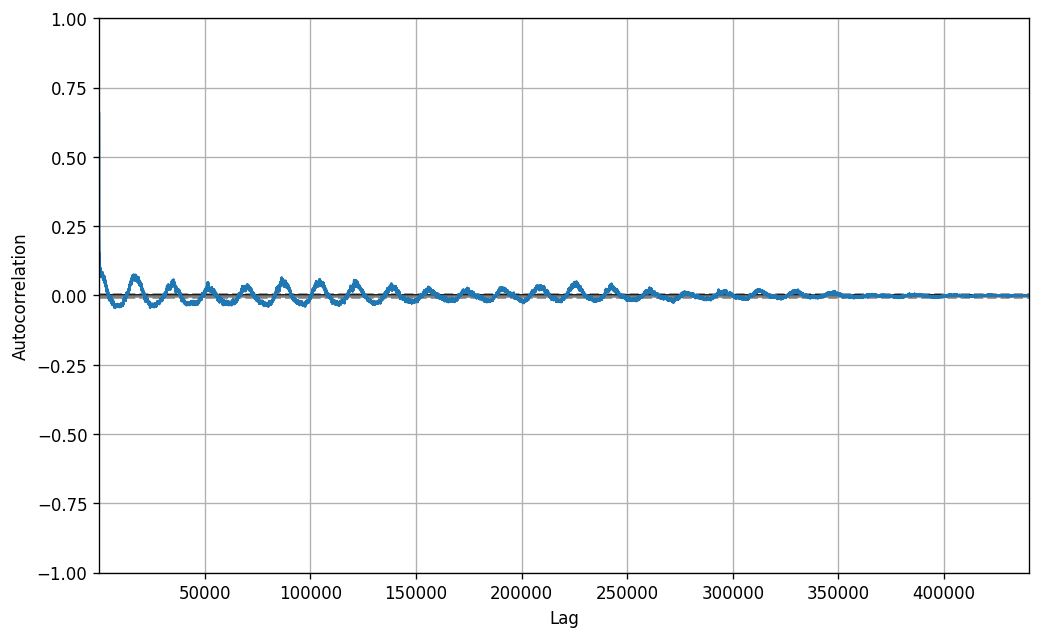

In [23]:
from pandas.plotting import autocorrelation_plot
series_id = no_nan_series[0]
# Draw Plot
series_0_data = new_train[new_train.series_id == series_id]
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})
autocorrelation_plot(series_0_data['enmo'].tolist())

## Based on the autocorrelation plot above, the enmo data is very close to white noise. There is very little autocorrelation except at lower lag values.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

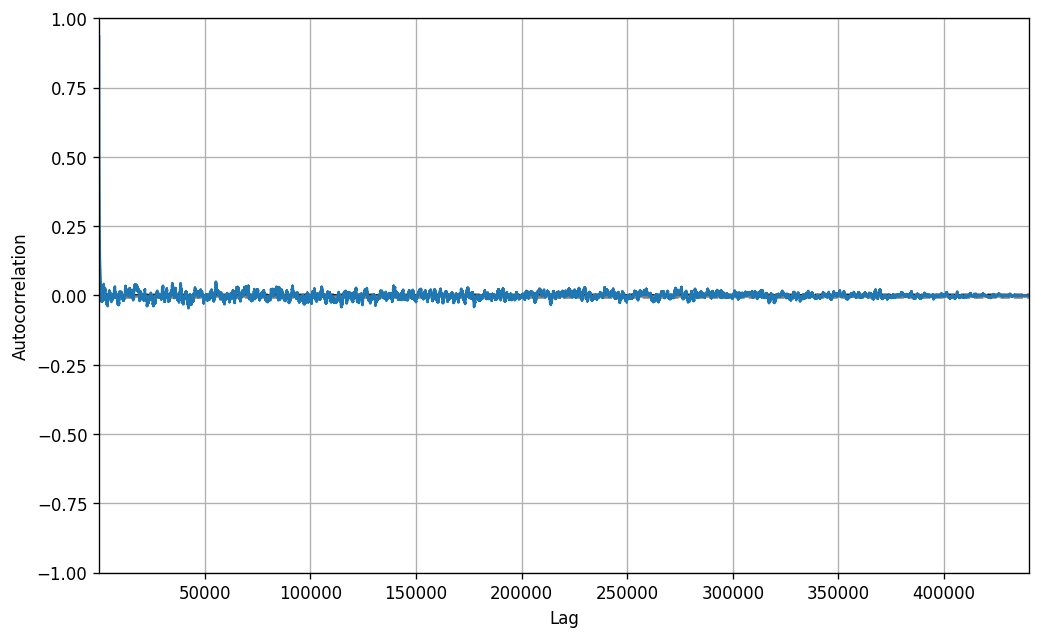

In [24]:
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})
autocorrelation_plot(series_0_data['anglez'].tolist())

### Lets look further on the enmo vs awake relationship since they had the highest correlation... Since our target variable (awake) is binary, it makes most sense to do a logistic regression.

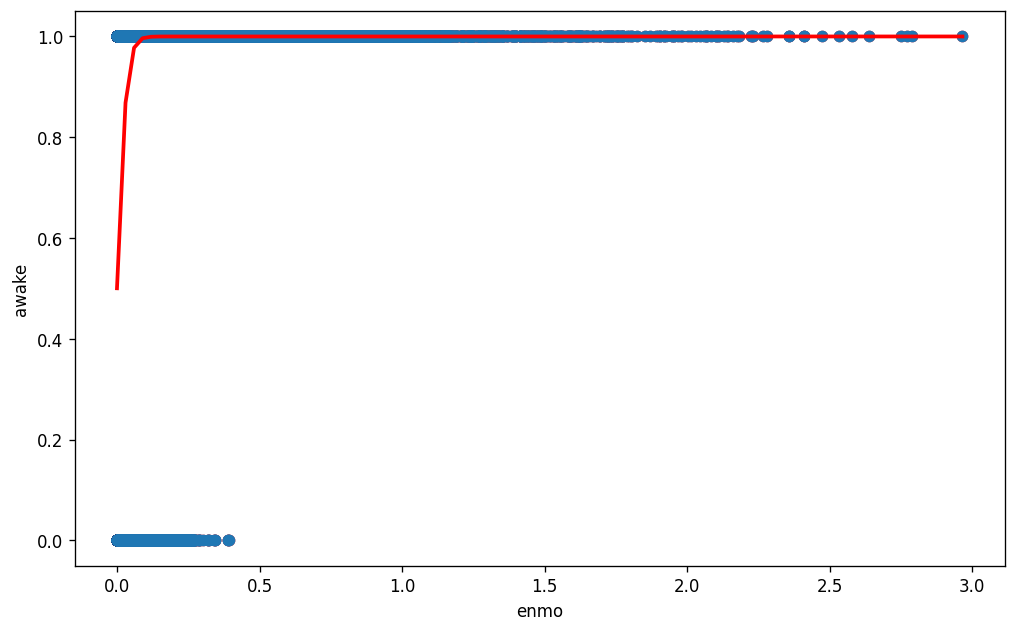

In [25]:

X = series_0_data['enmo']
Y = series_0_data['awake']
sns.regplot(x=X, y=Y, logistic=True, ci=None, color= "red")
plt.scatter(X, Y)
#plt.plot(X, log_reg.predict_proba(np.array(X).reshape(-1, 1))[:, 1], c='green', label='Logistic regression model')


## It seems that since there are very low enmo values, even in the awake state, the logistic regression cuts the probability that the person is asleep at low enmo values as well. But we also see that low enmo values usually indicate awake states. We could possibly exploit this.

Let do the same for anglez....

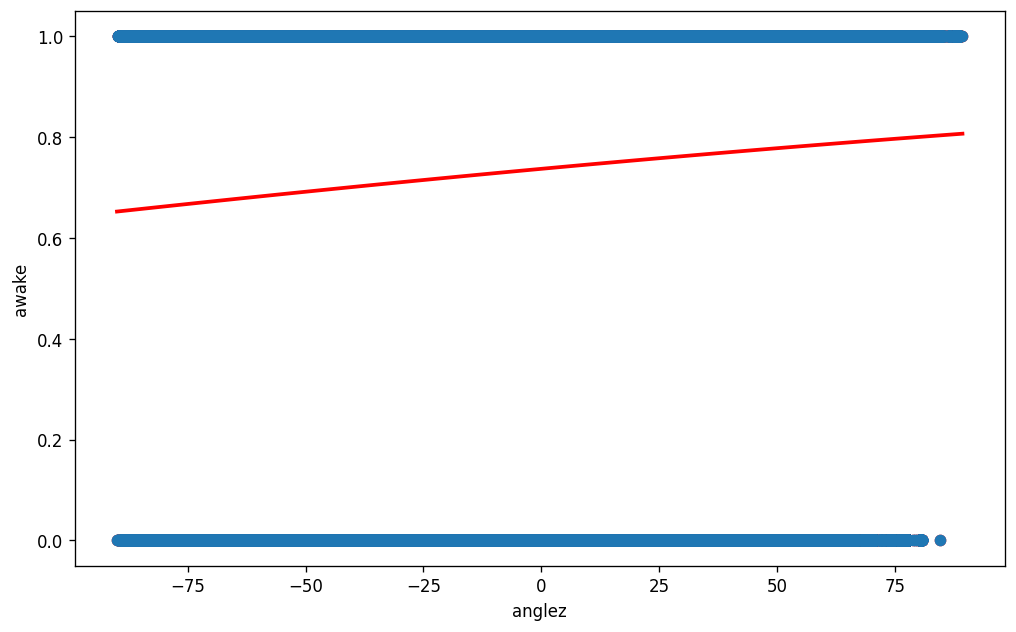

In [26]:
X = series_0_data['anglez']
Y = series_0_data['awake']
sns.regplot(x=X, y=Y, logistic=True, ci=None, color= "red")
plt.scatter(X, Y)

## ^^^ This is garbage, there is no difference in disribution of "awakeness" at low or high anglez's